In [20]:
import tensorflow as tf  
import matplotlib.pyplot as plt
import tifffile as tiff
import numpy as np
from PIL import Image
import fiona
import datetime
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import keras
import tensorflow_addons as tfa
import rasterio
import os
import pandas as pd
import cv2

import geopandas as gpd

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

from FUNCTIONS_Seedlings import *

In [19]:
test

NameError: name 'test' is not defined

## CUDA

In [21]:
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

2024-01-28 18:31:15.049207: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-01-28 18:31:15.056126: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-01-28 18:31:15.056601: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-01-28 18:31:15.082301: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-01-28 18:31:15.085258: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

### Functions

In [22]:
def filter_location(tif, tif_array, mask):
    '''READING raster with original data (tif) and label layer (mask) as numpy arrays & 
       FILTERING the boundaries of label layer using original tif layer.
       
       E.g. you produced tiled CHM for Surmont and have a label layer with wellpads (value 1) 
       and other areas (value 0) for the whole Surmont area. You planning to work with numpy arrays (no coordinates!)
       so you need first to be sure that you have tiled tif and the label of the exact same shape and areal coverage.
       In this case, you're cropping label layer (mask) using boundaries of your tiled original CHM (tif).
    
    tif:      Initial raster Layer with Nband - number of bands (1 by default)
    
    mask:     Label layer with EVERY pixel having a value of 1
              for object (e.g. line footprint in case of line mapping)
              and 0 for the rest area (e.g. lake, forest, peatland)
              Label should be of the same resolution as "tif"
    '''
    
    Nband = 1      #### CHANGE if needed

    ##### Getting its bounds (usually it has larger area that tiled "tif" layer)
    mask_left, mask_bottom, mask_right, mask_top = mask.bounds
    print('\nlabel layer bounds: ', mask.bounds)
    
    ##### Getting resolution of label layer (should be the same for tif and mask!)
    resolution = mask.res[0] ####
    print(resolution)
    
    ##### Calculating relative beginning of tif layer comparing to larger mask area
    bottom_new = int((mask_top - top) / resolution)
    height = int((top - bottom) / resolution)
    left_new = int((left-mask_left)/resolution)
    width = int((right - left) / resolution)
    print('NEW coverage is from {} + {} and from {} to {}'.format(bottom_new, height, left_new, width))
    
    ##### Reading label layer as numpy array
    mask_array = mask.read()
    print('Shape of mask array:', mask_array.shape)
    
    ##### Cropping label layer to be fully coaligned with original tif layer
    mask_array = mask_array[bottom_new:bottom_new+height, left_new:left_new+width]
    print('Shape of mask array:', mask_array.shape)
    return tif_array, mask_array

In [23]:
def label_list(folder, ending_img, ending_label):
    '''Making lists of training images and corresponding labels located in the directory. 
       For example, you have 10 png pictures with CHM and 10 png pictures with label layer and you want to make
       two lists, first with training CHM patches and second - with corresponding label layers. 
       
       folder: root directory with both training images and the corresponding labels
       ending_img:   training images ends with...? e.g. "rgb_256.png"
       ending_label: training labels ends with...? e.g. "label_256.png"
       
       Output:
       rgb_fls: list of training images (full path)
       label_fls: list of their labels (full path)
       '''
    
    ##### Preparing list of training images within the folder
    rgb_fls = [os.path.join(folder,files) for files in os.listdir(folder) if files.endswith(str(ending_img))]
    
    ##### Making the list of corresponding label patches
    label_fls = []

    for i in range(len(rgb_fls)):
        name = str(os.path.basename(rgb_fls[i])[:-len(ending_img)])+str(ending_label)
        if not os.path.exists(os.path.join(folder,name)):
            print(name)
            print('Oooops! Check the path!')
        label_fls.append(os.path.join(folder,name))
    return rgb_fls, label_fls

def checks(arr, norm = True):
    '''Simple checks for patches: they should be squarish and normilizes (if norm = TRUE)'''
    error = 0
    ##### Check have we normilized our image?
    if norm == True and arr.max() > 1:
        print('Houston, we have got a problem with 255!')
        error = 1
    ##### Check is it square patch?
    if arr.shape[0]!=arr.shape[1]:
        print('Houston, we have got a problem with shape!')
        error = 1
    return error

def norm(path, greyscale=False):
    '''Image normalization: first we read image using cv2 (greyscale or rgb), then we normilize it (up to 1)
    path: path to your greyscale or rgb image (usually .png)
    greyscale: check if yes
    
    output: normilized image
    
    '''
    
    ##### Reading the single image
    if greyscale == False:
        image = cv2.imread(path, cv2.IMREAD_COLOR)  # uint8 image
    else:
        image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)  # uint8 image
        print(image.shape)
        
    ##### Normilization of the image
    norm_image = cv2.normalize(image, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    print('The max value was {}, we nomalize it to {}'.format(image.max(), norm_image.max()))
    return norm_image

def shp_to_patches(shp, tif, src, size = 256):
    '''
    Transforming our shapefile with points to the pandas dataframe with patches (squares) around them!
    & Filtering shp by boundaries of the tif file.
    
    Input
    shp:          shapefile with (usually random) points. We'll build our training patches around them
    tif_path:     full path to original tif file with your data
    size:         size of your output patches (e.g. 256 pix * 256 pix)
    
    Output
    result:  pandas dataframe with 'image_path' of your original tif, 
             boundaries and center coordinates (minx, miny - non geographic, tile_xmin, tile_ymin - geographical)
             and your label (only for object detection).
    '''

    left, bottom, right, top = src.bounds
    resolution = src.res[0]
    print('RGB shape', tif.shape)
    print('Bounds: ', src.bounds)
        
    # Read shapefile
    gdf = gpd.read_file(shp)
    
    ##### Filtering shapefile by tif boundaries
    print('Initial number of points: ', len(gdf))
    gdf = gdf.geometry.bounds
    gdf = gdf[gdf.minx > left]
    gdf = gdf[gdf.minx < right]
    gdf = gdf[gdf.miny > bottom]
    gdf = gdf[gdf.miny < top]
    df = gdf.copy()
    print('Final number of points: ', len(gdf))
    
    # add filename
    df["image_path"] = os.path.basename(tif_path)
    print('Total number of points is ', len(df))
    
    # Transform project coordinates to image coordinates
    size = int(size/2)
    df["tile_x"] = (df.minx - left) / resolution
    df["center_x"] = df["tile_x"].astype(int)
    df["tile_xmin"] = df["tile_x"]-size
    df["tile_xmax"] = df["tile_x"]+size

    # UTM is given from the top, but origin of an image is top left
    df["tile_y"] = (top - df.miny) / resolution
    df["center_y"] = df["tile_y"].astype(int)
    df["tile_ymin"] = df["tile_y"]-size
    df["tile_ymax"] = df["tile_y"]+size
    
    print('Filtering tile x by...', tif.shape[2])
    print('Filtering tile y by...', tif.shape[1])

    df = df[df.tile_x < tif.shape[2]]
    df = df[df.tile_y < tif.shape[1]]
    
    for index, row in df.iterrows():
        df.loc[index, 'label'] = tif[0, int(row.tile_y), int(row.tile_x)]
        
    # select columns
    result = df[[
        "image_path", "minx", "miny", "center_x", "center_y", 'tile_xmin', 'tile_ymin'
    ]]

    return result


def patch_crop(array, mask, df, idnumber, size = 256, base_dir = '/media/irro/Irro/Irina/WellPads/wellpads_res05_512'):
    ''' Cropping patches to training images and labels of the certain size
        & saving the to the directory
        
        Input
        array:     original tif file (e.g. our CHM) read as numpy array
        mask:      corresponding label layer (e.g. pixel-wise mask of lines and non lines) read as nunpy array
        df:        pandas dataframe with coordinates of final patches we need to crop (by def shp_to_patches)
        idnumber:  init number of patch we use when saving it (e.g. patch_661.png means idnumber = 661)
        base_dir:  directory to save our patches!
        
        No output needed: check base_dir with patches.
    '''
    
    
    ##### Iterating over dataframe to crop patches of image and label:
    num = 0
    for index, row in df.iterrows():
        patch = array[int(row.center_y-size/2):int(row.center_y+size/2), int(row.center_x-size/2):int(row.center_x+size/2)]
        patch_l = mask[int(row.center_y-size/2):int(row.center_y+size/2), int(row.center_x-size/2):int(row.center_x+size/2)]
        
#         print(patch.shape)
#         print(patch_l.shape)
        
        #### Miss patches if they are not squares
        if patch.shape[0] != size or patch.shape[1] != size:
            continue  
        #### Miss patches if they are not squares 
        if patch_l.shape[0] < 100 or patch_l.shape[1] < 100:
            continue  
        
        patch = (patch - patch.min()) * (255.0 / (patch.max() - patch.min()))
        
        #### Change axis to fit for cv2 saving format:
        patch = np.moveaxis(patch, 0, -1) 
        patch_l = np.moveaxis(patch_l, 0, -1) 
        
      
            
        ##### Preparing FILENAMES for our patches! You may want to change this!        
        filename_p = "{}/{}_{}_{}.png".format(base_dir, 'line_patches', idnumber, 'rgb')
        filename_l = "{}/{}_{}_{}.png".format(base_dir, 'line_patches', idnumber, 'lab')
        
        print(filename_p)
#         print(filename_l)
        
        ##### SAVING patches into the folder (individually, training image and label)
        cv2.imwrite(filename_p, patch)
        cv2.imwrite(filename_l, patch_l)
        
        #### Counting patches and increasing index (so the next file will have +1 idnumber)
        num = num+1
        idnumber = idnumber+1

    print('The number of patches is', num)

In [5]:
def patch_in_batch(shp, tif_path, mask, size, base_dir, idnumber = 0):
    '''Function for cropping patches from the beginning. The same procedure for every tile:
    1) shapefile with points to dataframe with square coordinate WITHIN the tile boundaries
    2) reading tif_path and label layer to numpy array & filtering their boundaries to make correspond to each other
    with their shapes and covered area
    3) Vizualization just to check that everythin is right
    4) Cropping patches using dataframe and saving them to the base_dir
    
    Input
    shp:          shapefile with (usually random) points. We'll build our training patches around them
    tif_path:     full path to original tif file with your data
    mask:         Label layer with EVERY pixel having a value of 1
                  for object (e.g. line footprint in case of line mapping)
                  and 0 for the rest area (e.g. lake, forest, peatland)
                  Label should be of the same resolution as "tif"
    size:         size of your output patches (e.g. 256 pix * 256 pix) 
    base_dir:     directory to save our patches!
    idnumber:     init number of patch we use when saving it (e.g. patch_661.png means idnumber = 661)
    '''
    
    
    df = shp_to_patches(shp, tif_path)
    print('\nNumber of points within the shapefile is {}'.format(len(df)))
    
    rgb_array, mask_array = filter_location(tif_path, mask)
    
    ### IMPORTANT: If Lable != 1, you should change its value to 1 and non-ROI to 0
    mask_array = np.where(mask_array==0, 1, 0).astype(np.uint8)
    
    # Prediction vizualization:
    f, axarr = plt.subplots(1,2,figsize=(20,20))
    axarr[0].imshow(rgb_array[:500,:500])
    axarr[1].imshow(mask_array[:500,:500])
    
    patch = patch_crop(rgb_array, mask_array, df, 
            idnumber = idnumber, size = size, 
            base_dir = base_dir)    

In [6]:
import os
from rasterio import features

def patch_crop(image_array, mask_array, df, idnumber, size, base_dir, transform):
    for index, row in df.iterrows():
        xmin = int(row["tile_xmin"])
        xmax = int(row["tile_xmax"])
        ymin = int(row["tile_ymin"])
        ymax = int(row["tile_ymax"])

        cropped_image = image_array[ymin:ymax, xmin:xmax]
        cropped_mask = mask_array[ymin:ymax, xmin:xmax]
        # Check if cropped_image and cropped_mask have non-zero shapes
        if cropped_image.shape[0] == 0 or cropped_image.shape[1] == 0 or cropped_mask.shape[0] == 0 or cropped_mask.shape[1] == 0:
            print(f"Skipping tile {idnumber} index {index} due to zero shape.")
            continue

        # Normalize image to 8-bit
#         normalized_image = ((cropped_image - cropped_image.min()) * (255.0 / (cropped_image.max() - cropped_image.min()))).astype(np.uint8)
        normalized_image = cropped_image
    
    # Save cropped patches
        image_name = f"tile_{idnumber}_image_{index}.tif"
        mask_name = f"tile_{idnumber}_mask_{index}.tif"

        image_path = os.path.join(base_dir, image_name)
        mask_path = os.path.join(base_dir, mask_name)

        # Writing spatial info
        transform_patch = rasterio.windows.transform(window=Window(xmin, ymin, xmax-xmin, ymax-ymin), transform=transform)
        
        # Save the tiles as tiff files
        with rasterio.open(image_path, 'w', driver='GTiff', height=normalized_image.shape[0], 
                           width=normalized_image.shape[1], count=1, dtype=normalized_image.dtype, 
                           transform=transform_patch) as dest:
            dest.write(normalized_image, 1)
        
        with rasterio.open(mask_path, 'w', driver='GTiff', height=cropped_mask.shape[0], 
                           width=cropped_mask.shape[1], count=1, dtype=cropped_mask.dtype, 
                           transform=transform_patch) as dest:
            dest.write(cropped_mask, 1)

import rasterio
from rasterio.windows import Window
import geopandas as gpd
import os
import numpy as np

def transform_bounds(transform, x1, y1, x2, y2):
    """Transforms the bounds from pixel coordinates to spatial coordinates."""
    left, top = transform * (x1, y1)
    right, bottom = transform * (x2, y2)
    return left, bottom, right, top

def shp_to_tiles(shp, tif_path, tif_array, transform, size=256):
    left, bottom, right, top = transform_bounds(transform, 0, 0, tif_array.shape[2], tif_array.shape[1])

    resolution = transform[0]
    gdf = gpd.read_file(shp)
    # Filter shapefile based on tile bounds with a slight buffer for edge cases
    buffer = resolution * 2
    gdf = gdf[gdf.geometry.bounds.minx > left - buffer]
    gdf = gdf[gdf.geometry.bounds.maxx < right + buffer]
    gdf = gdf[gdf.geometry.bounds.miny > bottom - buffer]
    gdf = gdf[gdf.geometry.bounds.maxy < top + buffer]
    df = gdf.copy()
    df["image_path"] = os.path.basename(tif_path)

    half_size = int(size / 2)
    df["tile_x"] = (df.geometry.bounds.minx - left) / resolution
    df["center_x"] = df["tile_x"].astype(int)
    df["tile_xmin"] = df["tile_x"] - half_size
    df["tile_xmax"] = df["tile_x"] + half_size

    df["tile_y"] = (top - df.geometry.bounds.miny) / resolution
    df["center_y"] = df["tile_y"].astype(int)
    df["tile_ymin"] = df["tile_y"] - half_size
    df["tile_ymax"] = df["tile_y"] + half_size

    df = df[df.tile_x < tif_array.shape[2]]
    df = df[df.tile_y < tif_array.shape[1]]

    return df

def process_tile(tif_array, mask_array, shp, tif_path, size, patch_dir, i, transform):
    print('Working with tile number ', i)
    left, bottom, right, top = transform_bounds(transform, 0, 0, tif_array.shape[2], tif_array.shape[1])
    # Filter shp based on tile bounds and transform it into patches
    df = shp_to_tiles(shp, tif_path, tif_array, transform, size=size)
    print("Shapefile processed to patches.")
    
    patch_crop(tif_array[0,:,:], mask_array[0,:,:], df, idnumber=i, size=size, base_dir=patch_dir, transform=tif.window_transform(window))

# Patching

### Many files

In [7]:
train_dir = '/media/irro/Irro/HumanFootprint/'

##### List of tif files in the folder
mask_list = [os.path.join(train_dir,files) for files in os.listdir(train_dir) if files.startswith("Kirby_DSM_10cm_lab")
           and files.endswith('.tif')]

##### Check that you're reading only needed files
print(mask_list)

#### Train images and labels should correspond to each other within the list!
#### That's why sometimes it's easier to read label list and then just add right extension to it:

tif_list=[]
for x in mask_list:
#     print(x)
    path = x[:-11]+x[-7:]
    if not os.path.exists(path):
        print('Ooops with {}'.format(path))
    tif_list.append(path)
print(tif_list)

['/media/irro/Irro/HumanFootprint/Kirby_DSM_10cm_lab_BB1.tif', '/media/irro/Irro/HumanFootprint/Kirby_DSM_10cm_lab_BB2.tif', '/media/irro/Irro/HumanFootprint/Kirby_DSM_10cm_lab_BB3.tif', '/media/irro/Irro/HumanFootprint/Kirby_DSM_10cm_lab_BB4.tif', '/media/irro/Irro/HumanFootprint/Kirby_DSM_10cm_lab_BB5.tif', '/media/irro/Irro/HumanFootprint/Kirby_DSM_10cm_lab_BB6.tif', '/media/irro/Irro/HumanFootprint/Kirby_DSM_10cm_lab_BB7.tif']
['/media/irro/Irro/HumanFootprint/Kirby_DSM_10cm_BB1.tif', '/media/irro/Irro/HumanFootprint/Kirby_DSM_10cm_BB2.tif', '/media/irro/Irro/HumanFootprint/Kirby_DSM_10cm_BB3.tif', '/media/irro/Irro/HumanFootprint/Kirby_DSM_10cm_BB4.tif', '/media/irro/Irro/HumanFootprint/Kirby_DSM_10cm_BB5.tif', '/media/irro/Irro/HumanFootprint/Kirby_DSM_10cm_BB6.tif', '/media/irro/Irro/HumanFootprint/Kirby_DSM_10cm_BB7.tif']


In [8]:
train_dir = '/media/irro/Irro/HumanFootprint/Training_Images_256'

##### List of tif files in the folder
mask_list = [os.path.join(train_dir,files) for files in os.listdir(train_dir) if files.endswith('.tif')]

##### Check that you're reading only needed files
print(tif_list)
print(mask_list)

# Nband = 1      #### CHANGE if needed
i=0
size = 256
patch_dir = '/media/irro/Irro/HumanFootprint/Training_256_cnn'
shp = '/media/irro/Irro/HumanFootprint/random_cnn_lots.shp'

shp = "/media/irro/Irro/HumanFootprint/randompoints_10000_training.shp"

if not os.path.exists(patch_dir):
    os.makedirs(patch_dir)    

FileNotFoundError: [Errno 2] No such file or directory: '/media/irro/Irro/HumanFootprint/Training_Images_256'

### Summing two different resolution rasters

In [8]:
import rasterio
from rasterio.warp import reproject, Resampling
import numpy as np

def resample_raster(src_raster, dest_raster):
    """
    Resample the source raster to match the destination raster's resolution and extent.

    Args:
    - src_raster (rasterio.io.DatasetReader): Source raster dataset.
    - dest_raster (rasterio.io.DatasetReader): Destination raster dataset.

    Returns:
    - np.ndarray: The resampled array.
    """
    data = src_raster.read(1)
    resampled_data = np.zeros(dest_raster.shape, dtype=rasterio.float32)

    reproject(
        source=data,
        destination=resampled_data,
        src_transform=src_raster.transform,
        dst_transform=dest_raster.transform,
        src_crs=src_raster.crs,
        dst_crs=dest_raster.crs,
        resampling=Resampling.bilinear
    )

    return resampled_data

In [ ]:
mask_tif = '/media/irro/Irro/Kirby/DTM_50cm_binning_488_6131_496_6137_CNN9ep_256_179max.tif'
mask_tif_hr = '/media/irro/Irro/Kirby/DTM_10cm_binning_488_6131_496_6137_CNN9ep_512_358max.tif'

# Load the rasters
with rasterio.open(mask_tif) as low_res_raster, \
     rasterio.open(mask_tif_hr) as high_res_raster:

    # Resample high-resolution raster to match the low-resolution raster
    resampled_high_res = resample_raster(high_res_raster, low_res_raster)

    # Read the low-resolution raster data
    low_res_data = low_res_raster.read(1)

    # Sum the rasters
    summed_raster = low_res_data + resampled_high_res

    # Save the summed raster (optional)
    # You might want to adjust the metadata if needed
    with rasterio.open('/media/irro/Irro/HumanFootprint/Kirby_DTM50cm10cm_CNNsum.tif', 'w', **low_res_raster.meta) as dst:
        dst.write(summed_raster, 1)

### Patching by single tif: DTM norm 50 cm

In [9]:
train_tif = '/media/irro/Irro/HumanFootprint/Kirby_DTM50cm_norm_2022.vrt'
mask_tif = '/media/irro/Irro/Kirby/DTM_50cm_binning_488_6131_496_6137_CNN9ep_256_179max.tif'
mask_tif = '/media/irro/Irro/HumanFootprint/Kirby_DTM50cm10cm_CNNsum.tif'

# mask_tif_hr = '/media/irro/Irro/Kirby/DTM_10cm_binning_488_6131_496_6137_CNN9ep_512_358max.tif'

i=0
size = 512
patch_dir = f'/media/irro/Irro/HumanFootprint/DTMnorm50cm_Training{size}'

if not os.path.exists(patch_dir):
    os.makedirs(patch_dir)  
    
shp = "/media/irro/Irro/HumanFootprint/randompoints_10000_training.shp"

In [78]:
### No NORMALIZATION here!

with rasterio.open(train_tif) as tif, rasterio.open(mask_tif) as mask:
    print(f'TIF shape: {tif.shape}, MASK shape: {mask.shape}')
    for x in range(0, tif.width, tif.shape[1]):
        for y in range(0, tif.height, tif.shape[0]):
            width = min(tif.shape[1], tif.shape[1] - x)
            height = min(tif.shape[0], tif.shape[0] - y)
            window = Window(x, y, width, height)
            print(window)
            tif_array = tif.read(window=window)
            mask_array = mask.read(window=window)
            print('\nRead')
            process_tile(tif_array, mask_array, shp, train_tif, size, patch_dir, i, tif.window_transform(window))
            i += 1

TIF shape: (12951, 18000), MASK shape: (12951, 18000)
Window(col_off=0, row_off=0, width=18000, height=12951)

Read
Working with tile number  0
Shapefile processed to patches.


### Patching by single tif: DTM 

In [10]:
train_tif = '/media/irro/Irro/Kirby/DTM_10cm_binning_488_6131_496_6137.tif'
train_tif = '/media/irro/Irro/Kirby/DTM_50cm_binning_488_6131_496_6137.tif'

mask_tif = '/media/irro/Irro/Kirby/DTM_10cm_binning_488_6131_496_6137_CNNover50e_256_200.tif'
mask_tif = '/media/irro/Irro/Kirby/DTM_50cm_binning_488_6131_496_6137_CNNover50e_256_200.tif'

tif_list = [train_tif]
mask_list = [mask_tif]

# Nband = 1      #### CHANGE if needed
i=0
size = 512
patch_dir = '/media/irro/Irro/HumanFootprint/DTM50cm_Training_256_cnn'
patch_dir = '/media/irro/Irro/HumanFootprint/DTM_Training_512_cnn'

# shp = '/media/irro/Irro/HumanFootprint/random_cnn_lots.shp'
shp = "/media/irro/Irro/HumanFootprint/randompoints_10000_training.shp"

if not os.path.exists(patch_dir):
    os.makedirs(patch_dir)   

### Patching from Tif List

In [11]:
# tile_width, tile_height = 10000, 10000
# i = 0

# for tif_path, mask_path in zip(tif_list, mask_list):
#     print(mask_path)
#     with rasterio.open(tif_path) as tif, rasterio.open(mask_path) as mask:
#         for x in range(0, tif.width, tile_width):
#             for y in range(0, tif.height, tile_height):
#                 width = min(tile_width, tif.width - x)
#                 height = min(tile_height, tif.height - y)
#                 window = Window(x, y, width, height)
                
#                 tif_array = tif.read(window=window)
#                 mask_array = mask.read(window=window)
#                 print('\nRead')
#                 process_tile(tif_array, mask_array, shp, tif_path, size, patch_dir, i, tif.window_transform(window))
#                 i += 1

### READING

In [12]:
import os

print(patch_dir)

# Getting all files ending with .tif
all_files = [f for f in os.listdir(patch_dir) if f.endswith('.tif')]

# Filtering out the image files
train_images = [os.path.join(patch_dir, f) for f in all_files if 'image' in f]

# Deriving the mask filenames from the image filenames and checking if they exist
train_labels = [os.path.join(patch_dir, f.replace('image', 'mask')) for f in train_images if os.path.isfile(os.path.join(patch_dir, f.replace('image', 'mask')))]

print(f"Total training images: {len(train_images)}")
print(f"Total training labels: {len(train_labels)}")

print(train_images[10])
print(train_labels[10])

from sklearn.model_selection import train_test_split

train_ratio = 0.9
validation_ratio = 0.1

# Split dataset into training and validation sets
train_images, val_images, train_labels, val_labels = train_test_split(
    train_images, train_labels, test_size=1 - train_ratio, random_state=42
)

print(f"Number of training samples: {len(train_images)}")
print(f"Number of validation samples: {len(val_images)}")

/media/irro/Irro/HumanFootprint/DTM_Training_512_cnn
Total training images: 0
Total training labels: 0


IndexError: list index out of range

In [14]:
import tensorflow as tf
import numpy as np
import rasterio
from scipy.ndimage import label
from skimage.morphology import skeletonize, dilation, square

from skimage.morphology import skeletonize, dilation, square
import numpy as np

def skeletonize_and_buffer(mask, buffer_size=3):
    """
    Apply skeletonization to the mask and then buffer it back to a constant width.

    Args:
    - mask (np.ndarray): The binary mask array.
    - buffer_size (int): The width to buffer the skeletonized mask.

    Returns:
    - np.ndarray: The buffered mask.
    """
    # Ensure the mask is 2D
    if mask.ndim == 3 and mask.shape[-1] == 1:
        mask = np.squeeze(mask, axis=-1)

    # Skeletonize
    skeleton = skeletonize(mask)

    # Buffer/Dilate the skeleton
    buffered_mask = dilation(skeleton, square(buffer_size))

    # If needed, reshape back to original dimensions
    if mask.ndim == 3:
        buffered_mask = np.expand_dims(buffered_mask, axis=-1)

    return buffered_mask

def normalize_image(image):
    """
    Normalize the image to have pixel values between 0 and 1.

    Args:
    - image (np.ndarray): The input image array.

    Returns:
    - np.ndarray: The normalized image array.
    """
    min_val = np.min(image)
    max_val = np.max(image)
    normalized_image = (image - min_val) / (max_val - min_val)
    return normalized_image

def remove_small_objects(mask, min_size=200):
    labeled_mask, num_features = label(mask)
    small_objects_mask = np.zeros_like(mask)
    
    for i in range(1, num_features + 1):
        component = np.where(labeled_mask == i, 1, 0)
        if np.sum(component) < min_size:
            small_objects_mask += component
    
    return mask - small_objects_mask


import matplotlib.pyplot as plt

def plot_images_masks(images, masks):
    num = min(images.shape[0], 5)  # Get the number of samples or 5, whichever is smaller

    fig, axs = plt.subplots(num, 2, figsize=(10, 5*num))

    for i in range(num):
        axs[i, 0].imshow(images[i, :, :, 0], cmap='gray')
        axs[i, 0].axis('off')
        axs[i, 0].set_title('Image')

        axs[i, 1].imshow(masks[i, :, :, 0], cmap='gray')
        axs[i, 1].axis('off')
        axs[i, 1].set_title('Mask')

    plt.tight_layout()
    plt.show()

class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, image_list, mask_list, batch_size=32, image_size=(256, 256), shuffle=True, augment=False):
        self.image_list = image_list
        self.mask_list = mask_list
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.augment = augment
        self.indices = np.arange(len(self.image_list))
        self.image_list, self.mask_list = self.validate_image_dimensions()
        self.indices = np.arange(len(self.image_list))

        if self.shuffle:
            np.random.shuffle(self.indices)

    def __len__(self):
        return len(self.image_list) // self.batch_size
    
    def validate_image_dimensions(self, threshold=512):
        valid_image_list = []
        valid_mask_list = []

        for img_path, mask_path in zip(self.image_list, self.mask_list):
            with rasterio.open(img_path) as src:
                if src.shape[0] < threshold or src.shape[1] < threshold:
                    continue

            valid_image_list.append(img_path)
            valid_mask_list.append(mask_path)

        return valid_image_list, valid_mask_list

    def augment_image(self, image, mask):
        # Horizontal flipping
        if tf.random.uniform(()) > 0.5:
            image = tf.image.flip_left_right(image)
            mask = tf.image.flip_left_right(mask)

        # Rotations
        k = tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)
        image = tf.image.rot90(image, k=k)
        mask = tf.image.rot90(mask, k=k)

        # Random brightness & contrast
        image = tf.image.random_brightness(image, max_delta=0.1)
        image = tf.image.random_contrast(image, lower=0.9, upper=1.1)

        return image, mask

    def __getitem__(self, index):
        indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        batch_image_paths = [self.image_list[i] for i in indices]
        batch_mask_paths = [self.mask_list[i] for i in indices]
        
        valid_samples = 0
        
        X = np.zeros((self.batch_size, *self.image_size, 1), dtype=np.float32)  # Assuming grayscale images
        y = np.zeros((self.batch_size, *self.image_size, 1), dtype=np.float32)  # Assuming grayscale masks
        
        for i, (img_path, mask_path) in enumerate(zip(batch_image_paths, batch_mask_paths)):
            # Load and preprocess the image using rasterio
            with rasterio.open(img_path) as src:
                img = src.read(1)  # Read the first band. Adjust if your data is different.
                img = np.expand_dims(img, axis=-1)
                img = tf.image.resize(img, self.image_size)
#                 img = img / 255.0
                img = normalize_image(img)
    
            # Load and preprocess the mask using rasterio
            with rasterio.open(mask_path) as src:
                mask = src.read(1)  # Read the first band. Adjust if your data is different.
                mask = np.expand_dims(mask, axis=-1)
                mask = tf.image.resize(mask, self.image_size)
                
                
                mask = tf.where(mask > 15, 1, 0)  # Binarize the mask
                mask = remove_small_objects(mask, min_size = 30)  # Remove small objects
                
#                 # Binarize with the first threshold and remove small objects
#                 mask_threshold_5 = tf.where(mask > 5, 1, 0)
#                 mask_noises_removed = remove_small_objects(mask_threshold_5, min_size=50)

#                 # Binarize with the second threshold
#                 mask_threshold_15 = tf.where(mask > 30, 1, 0)

#                 # Use the result of the first step to refine the second mask
#                 # Keep only the larger objects identified in the first iteration
#                 mask = tf.where(mask_noises_removed == 1, mask_threshold_15, 0)
    
                if skeletonize == True:
                    mask = skeletonize_and_buffer(mask, buffer_size=1)
                    mask = np.expand_dims(mask, axis=-1)
        
                # Convert TensorFlow tensors back to numpy arrays
                img = img.numpy()
                mask = mask.numpy()

#                 # Check if the mask has less than 500 ones
#                 if np.sum(mask) < 500:
#                     continue  # Skip this pair

                # Apply augmentation
                if self.augment:
                    img, mask = self.augment_image(img, mask)

                # Assign to the batch arrays
                X[valid_samples] = img
                y[valid_samples] = mask

                valid_samples += 1

        # Return only the valid samples in the batch
        return X[:valid_samples], y[:valid_samples]

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)


In [136]:
batch_size = 2
size = 512

image_size = (size, size)
print('Patch Size: ', image_size)

train_gen = DataGenerator(train_images, train_labels, batch_size=batch_size, image_size=image_size, shuffle=True)
val_gen = DataGenerator(val_images, val_labels, batch_size=batch_size, image_size=image_size, shuffle=False)

Patch Size:  (512, 512)


(2, 512, 512, 1)
(2, 512, 512, 1)
1.0
0.0


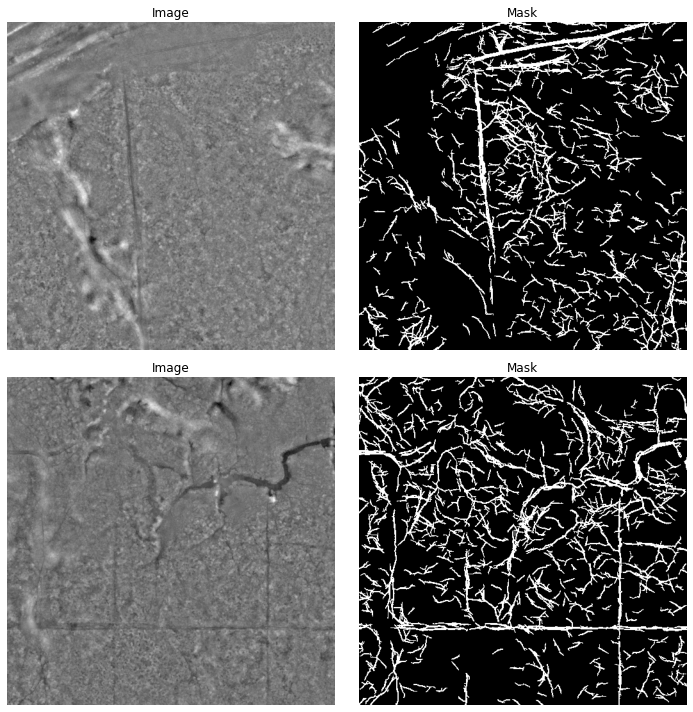

In [137]:
X_batch, y_batch = train_gen[15]
X_batch, y_batch = val_gen[13]

print(X_batch.shape)
print(y_batch.shape)
print(X_batch.max())
print(X_batch.min())

# Plot images and masks
plot_images_masks(X_batch, y_batch)

# Define the U-Net Model

In [24]:
def iou(y_true, y_pred, smooth=1e-6):
    # Flatten the input tensors
    y_true = tf.reshape(y_true, [-1])
    y_pred = tf.reshape(y_pred, [-1])

    # Calculate the intersections and unions
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection

    return (intersection + smooth) / (union + smooth)

def iou_thresholded(y_true, y_pred, threshold=0.5, smooth=1e-6):
    y_pred = tf.cast(y_pred > threshold, dtype=tf.float32)
    return iou(y_true, y_pred, smooth)


In [25]:
from keras_unet.models import custom_unet
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint

size = 512
input_shape = (size, size, 1)  # Add channel dimension
print(input_shape)
# 2. Define Model
model = custom_unet(
    input_shape,
    filters=32,
    use_batch_norm=True,
    dropout=0.3,
    num_classes=1,  # Changed this to 3
    output_activation='sigmoid'  # Changed this to 'softmax'
)

(512, 512, 1)


In [26]:
# Compile your model
model.compile(optimizer=tf.keras.optimizers.Adam(), 
              loss='binary_crossentropy', 
              metrics=[iou, iou_thresholded])

# Early stopping and learning rate reduction on plateau
earlystopper = EarlyStopping(patience=1, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

# Define the path and filename structure. You can modify this according to your needs.
checkpoint_filepath = "/media/irro/Irro/CNN_Models/HF_lesstrails_DTMnorm50cm_512_epoch_{epoch:02d}_valloss_{val_loss:.2f}.h5"

checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_best_only=False,  # Only save a model if `val_loss` has improved.
    monitor='loss',
    mode='min',  # Because you want to minimize the validation loss.
    verbose=1  # Verbosity mode, 1 means it will print logs.
)

In [27]:
import gc
gc.collect()

61836

### Training starts here...

In [160]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=5,
    steps_per_epoch=len(train_gen),
    validation_steps=len(val_gen),
    callbacks=[earlystopper, reduce_lr, checkpoint_callback]
)


Epoch 1/5
2878/2878 [==============================] - ETA: 0s - loss: 0.1737 - iou: 0.4299 - iou_thresholded: 0.5277
Epoch 1: saving model to /media/irro/Irro/CNN_Models/HF_lesstrails_DTMnorm50cm_512_epoch_01_valloss_0.20.h5
2878/2878 [==============================] - 14685s 5s/step - loss: 0.1737 - iou: 0.4299 - iou_thresholded: 0.5277 - val_loss: 0.2005 - val_iou: 0.4179 - val_iou_thresholded: 0.4964 - lr: 0.0010
Epoch 2/5
2878/2878 [==============================] - ETA: 0s - loss: 0.1707 - iou: 0.4370 - iou_thresholded: 0.5350
Epoch 2: saving model to /media/irro/Irro/CNN_Models/HF_lesstrails_DTMnorm50cm_512_epoch_02_valloss_0.26.h5
2878/2878 [==============================] - 13440s 5s/step - loss: 0.1707 - iou: 0.4370 - iou_thresholded: 0.5350 - val_loss: 0.2602 - val_iou: 0.3647 - val_iou_thresholded: 0.4088 - lr: 0.0010
Epoch 2: early stopping


### Plot

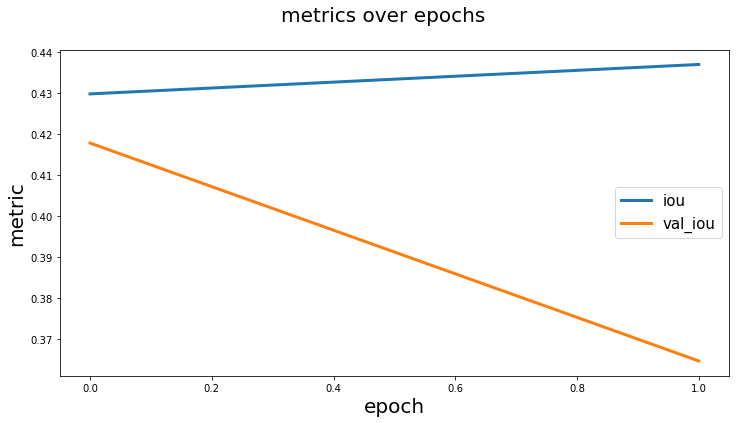

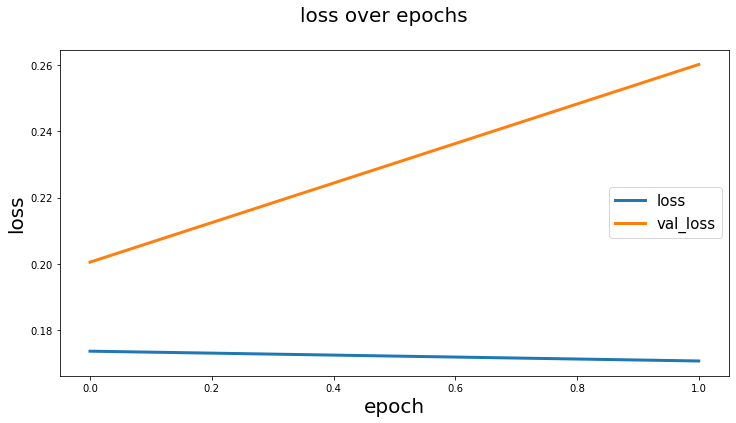

In [161]:
from keras_unet.utils import plot_segm_history
plot_segm_history(history)

### Test

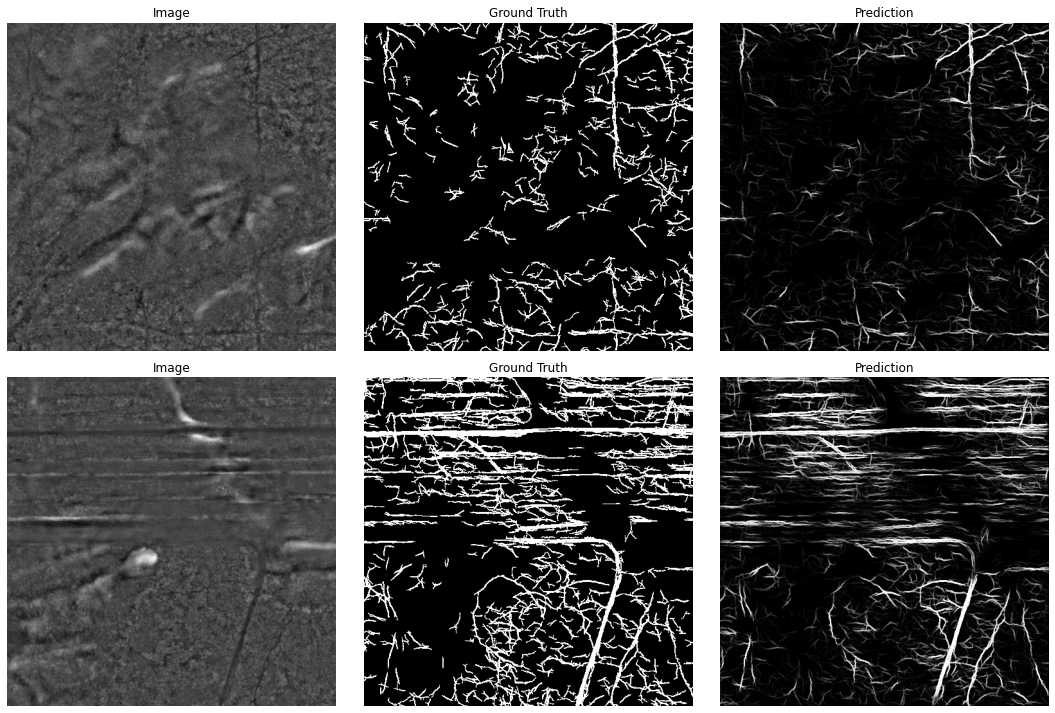

In [162]:
import matplotlib.pyplot as plt

def plot_predictions_vs_ground_truth(model, val_datagen, num_samples=2):
    """
    Plots predictions vs ground truth for a given number of samples from the validation data generator.

    Parameters:
    - model: Trained model.
    - val_datagen: Validation data generator.
    - num_samples: Number of samples to plot.
    """
    # Get a batch from the validation data generator
    images, ground_truths = val_datagen.__getitem__(10)
    
    # Predict using the model
    predictions = model.predict(images)
#     print(predictions)
    # Plot
    fig, axs = plt.subplots(num_samples, 3, figsize=(15, 5*num_samples))
    
    for i in range(num_samples):
        axs[i, 0].imshow(images[i].squeeze(), cmap='gray')
        axs[i, 0].set_title('Image')
        axs[i, 0].axis('off')

        axs[i, 1].imshow(ground_truths[i].squeeze(), cmap='gray')
        axs[i, 1].set_title('Ground Truth')
        axs[i, 1].axis('off')

        axs[i, 2].imshow(predictions[i].squeeze(), cmap='gray')
        axs[i, 2].set_title('Prediction')
        axs[i, 2].axis('off')
    
    plt.tight_layout()
    plt.show()

# Use the function
# plot_predictions_vs_ground_truth(model, val_gen)
plot_predictions_vs_ground_truth(model, train_gen)

## SAVE the Model

In [163]:
# size = 256
model_name = '/media/irro/Irro/CNN_Models/Human_DTM50cm_{}_byCNN_8ep.h5'.format(size)
model_name = '/media/irro/Irro/CNN_Models/Human_lesstrails_DTM10_{}_byCNN_7ep.h5'.format(size)
model_name = '/media/irro/Irro/CNN_Models/Human_DTM_{}_byCNN_9ep.h5'.format(size)
model_name = '/media/irro/Irro/CNN_Models/Human_DTMnorm50_{}_byCNN_5ep.h5'.format(size)

print(model_name)
### Saving the model! Careful!
# model.save(model_name)
# print(model_name)

/media/irro/Irro/CNN_Models/Human_DTMnorm50_512_byCNN_5ep.h5


## LOAD the Model

In [28]:
# model_name = '/media/irro/Irro/CNN_Models/Human_lots_256_byCNN.h5'
# model_name = '/media/irro/Irro/CNN_Models/Human_lots_256_byCNN_test.h5'
model_name = '/media/irro/Irro/CNN_Models/Human_DTM_512_byCNN_9ep.h5'
# model_name = '/media/irro/Irro/CNN_Models/Human_DTM50cm_{}_byCNN_8ep.h5'.format(size)
# model_name = '/media/irro/Irro/CNN_Models/Human_DTM_{}_byCNN_9ep.h5'.format(size)
# model_name = '/media/irro/Irro/CNN_Models/HumanFootprint/Human_lesstrails_DTM10_512_byCNN_7ep.h5'
model_name = '/media/irro/Irro/CNN_Models/HumanFootprint/Human_DTM_512_byCNN_9ep_good.h5'

model.load_weights(model_name)

# Predict

In [164]:
# import numpy as np
# import gc
# import tifffile as tiff
# import rasterio
# import matplotlib.pyplot as plt
# from skimage import exposure
# from tqdm import tqdm

# BLOCK_SIZE = 256

# def windowed_write(dst, array, BLOCK_SIZE=4096):
#     num_rows, num_cols = array.shape
#     row_windows = range(0, num_rows, BLOCK_SIZE)
#     col_windows = range(0, num_cols, BLOCK_SIZE)
    
#     for row in row_windows:
#         for col in col_windows:
#             window = ((row, min(row + BLOCK_SIZE, num_rows)), 
#                       (col, min(col + BLOCK_SIZE, num_cols)))
#             dst.write(array[window[0][0]:window[0][1], window[1][0]:window[1][1]], window=window, indexes=1)

# def pad_image(data, patch_size, stride):
#     height, width = data.shape[:2]
#     pad_height = (np.ceil(height/stride) * stride - height).astype(int)
#     pad_width = (np.ceil(width/stride) * stride - width).astype(int)
    
#     if len(data.shape) == 3:
#         padded_data = np.pad(data, ((0, pad_height), (0, pad_width), (0, 0)), mode='constant')
#     else:
#         padded_data = np.pad(data, ((0, pad_height), (0, pad_width)), mode='constant')
    
#     return padded_data

# def generate_overlapping_patches(data, patch_size, stride):
#     height, width = data.shape[:2]
#     patches = []

#     for i in range(0, height-patch_size+1, stride):
#         for j in range(0, width-patch_size+1, stride):
#             patches.append(data[i:i+patch_size, j:j+patch_size])

#     return patches

# def predict_tif(model, path, patch_size, overlap_size):
#     data = tiff.imread(path)
#     print('Read!')
#     original_height, original_width = data.shape[:2]
#     min_val = np.min(data[data > 100])
    
#     num_bands = data.shape[2] if len(data.shape) == 3 else 1
#     stride = patch_size - overlap_size
    
#     data = pad_image(data, patch_size, stride)
#     print('Padded!')
#     patches = generate_overlapping_patches(data, patch_size, stride)
    
#     pred = np.zeros(data.shape[:2], dtype=np.uint16)
#     counts = np.zeros(data.shape[:2], dtype=np.uint8)

#     for i, patch in tqdm(enumerate(patches), total=len(patches)):
#         patch = np.where(patch < 500, min_val, patch)

#         # Normalize
#         if patch.max() != patch.min():
#             patch_norm = ((patch - patch.min()) * (255.0 / (patch.max() - patch.min()))).astype(np.uint8)
#         else:
#             patch_norm = patch.astype(np.uint8)

#         patch_norm = patch_norm.reshape(1, patch.shape[0], patch.shape[1], num_bands) / 255.0

#         pred_patch = model.predict(patch_norm)
#         pred_patch = (pred_patch * 100).squeeze().astype(np.uint8)

#         if pred_patch.max() < 30:
#             patch_norm = exposure.equalize_hist(patch).astype(np.uint8) * 255
#             patch_norm = patch_norm.reshape(1, patch.shape[0], patch.shape[1], num_bands) / 255.0
#             pred_patch = model.predict(patch_norm)
#             pred_patch = (pred_patch * 100).squeeze().astype(np.uint8)

#         start_row = i // ((data.shape[1] - overlap_size) // stride) * stride
#         end_row = start_row + patch_size
#         start_col = i % ((data.shape[1] - overlap_size) // stride) * stride
#         end_col = start_col + patch_size

#         pred[start_row:end_row, start_col:end_col] = np.maximum(pred[start_row:end_row, start_col:end_col], pred_patch)
#         counts[start_row:end_row, start_col:end_col] += 1

# #     pred = (pred / (counts + 1e-10)).astype(np.uint16)  # Add a small value to avoid division by zero
#     pred = pred[:original_height, :original_width]

#     # Debugging print for final pred shape
#     print(f"Final stitched image shape: {pred.shape}")

#     plt.figure(figsize=(10, 10))
#     plt.imshow(pred, cmap='gray')
#     plt.title('Predicted Image without Overlaps')
#     plt.colorbar()
#     plt.show()
    
#     gc.collect()
    
#     output_path = path[:-4] + f'_CNNover50e_256_{overlap_size}.tif'
#     with rasterio.open(path) as src:
#         profile = src.profile
#         profile.update(dtype='uint8', nodata=0, compress='LZW', tiled=True, blockxsize=BLOCK_SIZE, blockysize=BLOCK_SIZE)

#         with rasterio.open(output_path, 'w', **profile) as dst:
#             windowed_write(dst, pred)
            
#     return output_path

In [29]:
import numpy as np
import gc
import tifffile as tiff
import rasterio
from rasterio.windows import Window
import matplotlib.pyplot as plt
from skimage import exposure
from tqdm import tqdm

BLOCK_SIZE = 256

def adjust_window(window, max_width, max_height):
    """
    Adjust the window dimensions if it goes beyond the image boundaries.
    """
    col_off, row_off, width, height = window.flatten()
    if col_off + width > max_width:
        width = max_width - col_off
    if row_off + height > max_height:
        height = max_height - row_off
    
    return Window(col_off, row_off, width, height)

def pad_to_shape(array, target_shape):
    """
    Pad a 2D array with zeros to the desired target shape.
    """
    diff_height = target_shape[0] - array.shape[0]
    diff_width = target_shape[1] - array.shape[1]
    
    padded_array = np.pad(array, ((0, diff_height), (0, diff_width), (0, 0)), 'constant')
    return padded_array

# def predict_patch_optimized(model, patch):
#     min_val = 450
#     patch = np.where(patch < min_val, min_val, patch)
        
#     # Normalize
#     if patch.max() != patch.min():
#         patch_norm = ((patch - patch.min()) * (255.0 / (patch.max() - patch.min()))).astype(np.uint8)
#     else:
#         patch_norm = patch.astype(np.uint8)
    
#     num_bands = patch.shape[2] if len(patch.shape) == 3 else 1
#     patch_norm = patch_norm.reshape(1, patch.shape[0], patch.shape[1], num_bands) / 255.0
#     pred_patch = model.predict(patch_norm)
#     pred_patch = (pred_patch * 100).squeeze().astype(np.uint8)

#     if pred_patch.max() < 30:
#         patch_norm = exposure.equalize_hist(patch).astype(np.uint8) * 255
#         patch_norm = patch_norm.reshape(1, patch.shape[0], patch.shape[1], num_bands) / 255.0
#         pred_patch = model.predict(patch_norm)
#         pred_patch = (pred_patch * 100).squeeze().astype(np.uint8)
    
#     return pred_patch

def predict_patch_optimized(model, patch):
        
    # Normalize
    if patch.max() != patch.min():
        patch_norm = ((patch - patch.min()) * ((patch.max() - patch.min())))
    else:
        patch_norm = patch
        
    num_bands = patch.shape[2] if len(patch.shape) == 3 else 1
    patch_norm = patch_norm.reshape(1, patch.shape[0], patch.shape[1], num_bands)
    
    #     print(f'After NORM: max {patch_norm.max()} and min {patch_norm.min()}')
    pred_patch = model.predict(patch_norm)
    pred_patch = (pred_patch * 100).squeeze().astype(np.uint8)
    
    return pred_patch

def predict_tif_optimized(model, path, patch_size, overlap_size):
    stride = patch_size - overlap_size

    with rasterio.open(path) as src:
        original_height, original_width = src.shape
        pred_accumulator = np.zeros((original_height, original_width), dtype=np.uint8)
        counts = np.zeros((original_height, original_width), dtype=np.uint16)
        
        for i in tqdm(range(0, original_height, stride)):
            for j in range(0, original_width, stride):
                window = Window(j, i, patch_size, patch_size)
                window = adjust_window(window, original_width, original_height)

                patch = src.read(window=window)
                patch = np.moveaxis(patch, 0, -1)  # Move the channel dimension to the end

                if patch.shape[0] != patch_size or patch.shape[1] != patch_size:
                    patch = pad_to_shape(patch, (patch_size, patch_size))

                pred_patch = predict_patch_optimized(model, patch)

                col_off, row_off, width, height = map(int, window.flatten())

                # Make sure that pred_patch has the same shape as the portion we're updating in pred_accumulator
                pred_patch = pred_patch[:height, :width]

                pred_accumulator[row_off:row_off+height, col_off:col_off+width] = np.maximum(
                    pred_accumulator[row_off:row_off+height, col_off:col_off+width], pred_patch)
                counts[row_off:row_off+height, col_off:col_off+width] += 1

        
        # If you want average prediction (uncomment below)
        # final_pred = (pred_accumulator / (counts + 1e-10)).astype(np.uint8)
        
        # If you want max prediction (uncomment below)
        final_pred = pred_accumulator

        output_path = path[:-4] + f'_CNNover50e_256_{overlap_size}.tif'
        profile = src.profile.copy()
        profile.update(dtype='uint8', nodata=0, compress='LZW', tiled=True, blockxsize=BLOCK_SIZE, blockysize=BLOCK_SIZE)

        with rasterio.open(output_path, 'w', **profile) as dst:
            dst.write(final_pred[np.newaxis, :, :])

#     return output_path

# NEW model for DTM

In [30]:
import tifffile as tiff
import rasterio
from rasterio.windows import Window
import matplotlib.pyplot as plt
from skimage import exposure
from tqdm import tqdm

def predict_patch_optimized(model, patch):
    patch_norm = patch - patch.min()
    patch_norm = patch_norm[np.newaxis, ...]  # Add batch dimension
#     print(patch_norm.shape)
    prediction = model.predict(patch_norm)
#     print(prediction)
    # Scaling to 0-100
    scaled_pred = (prediction * 100).astype(np.uint8)
    return scaled_pred.squeeze()

In [38]:
import os
import rasterio
from rasterio.merge import merge

# Define the directory containing your raster tiles
input_folder = "/media/irro/Irro/Surmont/DTM10cm_2019/"
output_folder = "/media/irro/Irro/Surmont/DTM10cm_2019/merged/"

# Ensure the output folder exists
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Define the output file path
output_file = os.path.join(output_folder, "merged_output.tif")

# List all files in the directory
raster_files = [os.path.join(input_folder, file) for file in os.listdir(input_folder) if file.endswith('n.tif')]

# Open and read each raster file
datasets = [rasterio.open(file) for file in raster_files]

# Use rasterio's merge function to merge datasets
mosaic, out_trans = merge(datasets)

# Write the merged raster to a new file
with rasterio.open(output_file, 'w', driver='GTiff',
                   height=mosaic.shape[1], width=mosaic.shape[2],
                   count=1, dtype=str(mosaic.dtype),
                   crs=datasets[0].crs, transform=out_trans) as dest:
    dest.write(mosaic)

# Close datasets
for dataset in datasets:
    dataset.close()

print(f"Merged raster saved as {output_file}")

Merged raster saved as /media/irro/Irro/Surmont/DTM10cm_2019/merged/merged_output.tif


In [28]:
# path = '/media/irro/Irro/HumanFootprint/test_kirby_DTM.tif'
# path = '/media/irro/Irro/Kirby/DTM_50cm_binning_488_6131_496_6137.tif'
# path = '/media/irro/Irro/Kirby/DTM_10cm_binning_488_6131_496_6137.tif'

# path = '/media/irro/Irro/Kirby/DTM_10cm_binning_488_6131_496_6137.tif'

# # path = '/media/irro/Irro/Surmont/LiDAR_2022/DTM_Surmont_mosaic_50cm.tif'
# path = '/media/irro/Irro/HumanFootprint/DTM_10cm_KirbyFen.tif'
# path = '/media/irro/Irro/Surmont/LiDAR_2019/Surmont_DEM_2019.tif'

# patch_size = size
# overlap_size = int(size*0.8//10*10)
# stride = patch_size - overlap_size
# for path in tif_list:
#     with rasterio.open(path) as src:
#         profile = src.profile.copy()
#         original_height, original_width = src.shape
#         pred_accumulator = np.zeros((original_height, original_width), dtype=np.uint8)
#         counts = np.zeros((original_height, original_width), dtype=np.uint16)

#         for i in tqdm(range(0, original_height, stride)):
#             for j in range(0, original_width, stride):
#                 window = Window(j, i, patch_size, patch_size)
#                 window = adjust_window(window, original_width, original_height)

#                 patch = src.read(window=window)
#                 patch = np.moveaxis(patch, 0, -1)  # Move the channel dimension to the end

#                 if patch.shape[0] != patch_size or patch.shape[1] != patch_size:
#                     patch = pad_to_shape(patch, (patch_size, patch_size))

#                 pred_patch = predict_patch_optimized(model, patch)

#                 col_off, row_off, width, height = map(int, window.flatten())

#                 # Make sure that pred_patch has the same shape as the portion we're updating in pred_accumulator
#                 pred_patch = pred_patch[:height, :width]

#                 pred_accumulator[row_off:row_off+height, col_off:col_off+width] = np.maximum(
#                     pred_accumulator[row_off:row_off+height, col_off:col_off+width], pred_patch)
#                 counts[row_off:row_off+height, col_off:col_off+width] += 1

#         # If you want max prediction
#         final_pred = pred_accumulator

#         output_path = path[:-4] + f'_CNN9ep_{patch_size}_{overlap_size}max.tif'

#         profile.update(dtype='uint8', nodata=0, compress='LZW', tiled=True, blockxsize=BLOCK_SIZE, blockysize=BLOCK_SIZE)

#         with rasterio.open(output_path, 'w', **profile) as dst:
#             dst.write(final_pred[np.newaxis, :, :])
#             print('Saved to: ', output_path)

# Few blocks

In [ ]:
# path = '/media/irro/Irro/Kirby/DTM_10cm_binning_488_6131_496_6137.tif'

path = "/media/irro/Irro/Surmont/DTM10cm_2019/merged/merged_output.tif"
path = "/media/irro/Irro/Surmont/LiDAR_2022/Smoothed_DTM/CHH_505_6225_denoised.tif"
path = "/media/irro/Irro/Surmont/LiDAR_2022/Smoothed_DTM/CHH_505_6225_denoised.tif"

path = '/media/irro/Irro/Kirby/10cm_R6/CHH_491_6137_mean_6m.tif'
path = '/media/irro/Irro/HumanFootprint/PFT_KirbySouth_July2022_DTM.tif'

path = '/media/irro/Irro/Kirby/Kirby_10cm_normDTM6m.vrt'

patch_size = size
overlap_size = int(size*0.7)
stride = patch_size - overlap_size

def process_block(src, x_start, x_end, y_start, y_end, patch_size, stride, model):
    pred_accumulator = np.zeros((y_end - y_start, x_end - x_start), dtype=np.uint8)
    counts = np.zeros((y_end - y_start, x_end - x_start), dtype=np.uint16)

    for i in tqdm(range(y_start, y_end, stride)):
        for j in range(x_start, x_end, stride):
            window = Window(j, i, patch_size, patch_size)
            window = adjust_window(window, x_end, y_end)

            patch = src.read(window=window)
            patch = np.moveaxis(patch, 0, -1)

            if patch.shape[0] != patch_size or patch.shape[1] != patch_size:
                patch = pad_to_shape(patch, (patch_size, patch_size))

            pred_patch = predict_patch_optimized(model, patch)

            col_off, row_off, width, height = map(int, window.flatten())
            pred_patch = pred_patch[:height, :width]

            pred_accumulator[row_off-y_start:row_off+height-y_start, col_off-x_start:col_off+width-x_start] = np.maximum(
                pred_accumulator[row_off-y_start:row_off+height-y_start, col_off-x_start:col_off+width-x_start], pred_patch)
            counts[row_off-y_start:row_off+height-y_start, col_off-x_start:col_off+width-x_start] += 1

    return pred_accumulator

with rasterio.open(path) as src:
    original_height, original_width = src.shape
    block_width = original_width // 2
    block_height = original_height // 2
    profile = src.profile.copy()

    final_pred = np.zeros((original_height, original_width), dtype=np.uint8)

    for x_block in range(2):
        print('X: ', x_block)
        for y_block in range(2):
            print('Y: ', y_block)
                
            x_start = x_block * block_width
            x_end = x_start + block_width
            y_start = y_block * block_height
            y_end = y_start + block_height

            pred_block = process_block(src, x_start, x_end, y_start, y_end, patch_size, stride, model)
            final_pred[y_start:y_end, x_start:x_end] = pred_block

            # Adjust the transform for the block
            block_transform = src.transform * rasterio.Affine.translation(x_start, y_start)
            block_profile = profile.copy()
            block_profile.update(transform=block_transform, width=block_width, height=block_height, driver = 'GTiff')
            block_output_path = '/media/irro/Irro/Kirby/Kirby_normDTM10cm_CNN9ep_block_{x_block}_{y_block}.tif'
            
            # Write the block using the updated block_profile
            with rasterio.open(block_output_path, 'w', **block_profile) as dst:
                dst.write(pred_block[np.newaxis, :, :])
                print('Saved block to: ', block_output_path)

# Final step: Writing the entire dataset to a .tif file
output_path = path[:-4] + f'_{os.path.basename(model_name)[:-3]}_{patch_size}_{overlap_size}max.tif'
profile.update(dtype='uint8', nodata=0, compress='LZW', tiled=True, blockxsize=BLOCK_SIZE, blockysize=BLOCK_SIZE)

with rasterio.open(output_path, 'w', driver='GTiff', **profile) as dst:
    dst.write(final_pred[np.newaxis, :, :])
    print('Saved to: ', output_path)

X:  0
Y:  0


 50%|██████████████████▍                  | 105/211 [1:54:20<1:57:20, 66.42s/it]

### Predictions: mean

In [170]:
from tqdm import tqdm
import numpy as np
import rasterio
from rasterio.windows import Window

# Assuming your predict_patch_optimized and pad_to_shape functions are already defined.

path = '/media/irro/Irro/HumanFootprint/test_kirby_DTM.tif'
path = "/media/irro/Irro/Surmont/DTM10cm_2022/DTM10_2022_BERAtools/DTM10_2022_beratools.tif"
path = '/media/irro/Irro/Kirby/Kirby_2022_by_mean/CHH_488_6135.tif'
path = '/media/irro/Irro/HumanFootprint/Kirby_DTM50cm_norm_2022.vrt'

patch_size = 512

for over in [0.5]:
    overlap_size = int(patch_size*over//50*50)
    stride = patch_size - overlap_size
    BLOCK_SIZE = 4096  # Add this if it's not defined elsewhere.

    def adjust_window(window, max_width, max_height):
        col_off, row_off, width, height = window.flatten()
        if col_off + width > max_width:
            width = max_width - col_off
        if row_off + height > max_height:
            height = max_height - row_off
        return Window(col_off, row_off, width, height)

    with rasterio.open(path) as src:
        profile = src.profile.copy()
        original_height, original_width = src.shape

        # Placeholder for averaged predictions and counts
        pred_accumulator = np.zeros((original_height, original_width), dtype=np.float32)
        counts = np.zeros((original_height, original_width), dtype=np.uint16)

        for i in tqdm(range(0, original_height, stride)):
            for j in range(0, original_width, stride):
                window = Window(j, i, patch_size, patch_size)
                window = adjust_window(window, original_width, original_height)

                patch = src.read(window=window)
                patch = np.moveaxis(patch, 0, -1)  # Move the channel dimension to the end

                if patch.shape[0] != patch_size or patch.shape[1] != patch_size:
                    patch = pad_to_shape(patch, (patch_size, patch_size))

                pred_patch = predict_patch_optimized(model, patch)

                col_off, row_off, width, height = map(int, window.flatten())

                # Update pred_accumulator and counts
                pred_accumulator[row_off:row_off+height, col_off:col_off+width] += pred_patch[:height, :width]
                counts[row_off:row_off+height, col_off:col_off+width] += 1

        # Averaging the predictions
        averaged_predictions = pred_accumulator / counts
        averaged_predictions[np.isnan(averaged_predictions)] = 0  # Replace NaN values with 0, if any.

        # Convert averaged predictions to uint8
        final_pred = (averaged_predictions).astype(np.uint8)

        output_path = path[:-4] + f'_{os.path.basename(model_name)[:-3]}_{overlap_size}avg.tif'

        profile.update(driver='GTiff', dtype='uint8', nodata=0, compress='LZW', tiled=True, blockxsize=BLOCK_SIZE, blockysize=BLOCK_SIZE)

        with rasterio.open(output_path, 'w', **profile) as dst:
            dst.write(final_pred[np.newaxis, :, :])
            print('Saved to:', output_path)


100%|███████████████████████████████████████████| 50/50 [08:08<00:00,  9.77s/it]


Saved to: /media/irro/Irro/HumanFootprint/Kirby_DTM50cm_norm_2022_Human_DTMnorm50_512_byCNN_5ep_250avg.tif


In [169]:
os.path.basename(model_name)[:-3]

'Human_DTMnorm50_512_byCNN_5ep'

In [156]:
# Update profile for TIFF output
profile.update(driver='GTiff', dtype='uint8', nodata=0, compress='LZW', tiled=True, blockxsize=BLOCK_SIZE, blockysize=BLOCK_SIZE)

with rasterio.open(output_path, 'w', **profile) as dst:
    dst.write(final_pred[np.newaxis, :, :])
    print('Saved to:', output_path)

Saved to: /media/irro/Irro/HumanFootprint/Kirby_DTM50cm_norm_2022_CNN9ep_512_250avg.tif


In [155]:
profile

{'driver': 'VRT', 'dtype': 'uint8', 'nodata': 0, 'width': 18000, 'height': 12951, 'count': 1, 'crs': CRS.from_epsg(2956), 'transform': Affine(0.5, 0.0, 488000.0,
       0.0, -0.5, 6138000.0), 'blockxsize': 4096, 'blockysize': 4096, 'tiled': True, 'compress': 'LZW'}

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(final_pred, cmap='gray')
plt.title('Predicted Image without Overlaps')
plt.colorbar()
plt.show()

In [345]:
print(final_pred[100:200, 100])

[  0   0   0   0   0   0   0   0   0 190 249  46 195  20 103 186 143 228
 100 101  62  67 115 248 252 254 170  42   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0  85  85  42   0   0   0   0   0   0
   0   0   0   0   0   0   0   0 127 125 123 207 165 165 188 221 255  31
   0   0   0  31  31  31  31   0   0   0   0   0   0   0   0   0   0   0
   0   0  31 223 158 190 158  30  31   0]


### Read sample patch and get predictions

[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


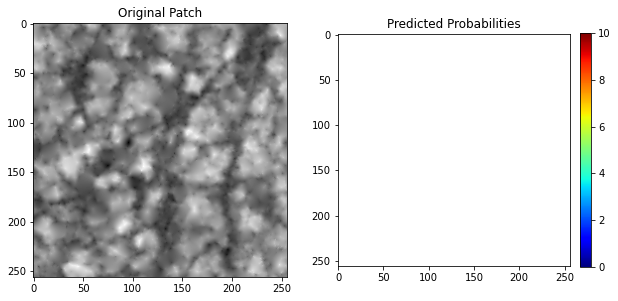

In [243]:
import matplotlib.pyplot as plt

# Define a function to plot original and predicted patches
def plot_predictions(original_patch, prediction):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    axs[0].imshow(original_patch.squeeze(), cmap='gray')  # Assuming grayscale
    axs[0].set_title('Original Patch')

    im = axs[1].imshow(prediction, cmap='jet', vmin=0, vmax=10)  # Probabilities range from 0 to 100
    axs[1].set_title('Predicted Probabilities')

    # Add colorbar to help interpret probabilities
    fig.colorbar(im, ax=axs[1], orientation='vertical', fraction=0.046, pad=0.04)

    plt.show()

# Reading a sample patch from the image and getting its prediction
with rasterio.open(path) as src:
    # Define a sample window (you can change coordinates based on your interest)
    window = Window(1000, 1000, patch_size, patch_size)

    patch = src.read(window=window)
    patch = np.moveaxis(patch, 0, -1)
    
    if patch.shape[0] != patch_size or patch.shape[1] != patch_size:
        patch = pad_to_shape(patch, (patch_size, patch_size))

    predicted_probabilities = predict_patch_optimized(model, patch)
    print(predicted_probabilities)
    plot_predictions(patch, predicted_probabilities)


## For folder

In [32]:
test_dir = '/media/irro/Irro/Surmont/10cm/subset4'
#### Making a list of tifs which NOT end with... "CNN256.tif" - you should put your own extension
test_list = [os.path.join(test_dir,files) for files in os.listdir(test_dir) if files.endswith("DSM.tif")]

for path in test_list:
    print(path)
    pred = predict_tif(model, path, 256, 50)

/media/irro/Irro/Surmont/10cm/subset4/514_622410cmDSM.tif
ERROR! Session/line number was not unique in database. History logging moved to new session 1871


100%|███████████████████████████████████████| 2304/2304 [05:15<00:00,  7.30it/s]
/tmp/ipykernel_4036/459356350.py:59: RuntimeWarning: divide by zero encountered in floor_divide
  pred //= patch_count  # Integer division


Saved to:  /media/irro/Irro/Surmont/10cm/subset4/514_622410cmDSM_CNNover_256.tif
/media/irro/Irro/Surmont/10cm/subset4/500_622410cmDSM.tif


100%|███████████████████████████████████████| 2304/2304 [05:03<00:00,  7.59it/s]


Saved to:  /media/irro/Irro/Surmont/10cm/subset4/500_622410cmDSM_CNNover_256.tif
/media/irro/Irro/Surmont/10cm/subset4/500_622510cmDSM.tif


100%|███████████████████████████████████████| 2304/2304 [04:36<00:00,  8.33it/s]


Saved to:  /media/irro/Irro/Surmont/10cm/subset4/500_622510cmDSM_CNNover_256.tif
/media/irro/Irro/Surmont/10cm/subset4/501_622410cmDSM.tif


100%|███████████████████████████████████████| 2304/2304 [03:23<00:00, 11.31it/s]


Saved to:  /media/irro/Irro/Surmont/10cm/subset4/501_622410cmDSM_CNNover_256.tif
/media/irro/Irro/Surmont/10cm/subset4/501_622510cmDSM.tif


100%|███████████████████████████████████████| 2304/2304 [03:45<00:00, 10.20it/s]


Saved to:  /media/irro/Irro/Surmont/10cm/subset4/501_622510cmDSM_CNNover_256.tif
/media/irro/Irro/Surmont/10cm/subset4/502_622410cmDSM.tif


100%|███████████████████████████████████████| 2304/2304 [03:01<00:00, 12.69it/s]


Saved to:  /media/irro/Irro/Surmont/10cm/subset4/502_622410cmDSM_CNNover_256.tif
/media/irro/Irro/Surmont/10cm/subset4/502_622510cmDSM.tif


100%|███████████████████████████████████████| 2304/2304 [03:06<00:00, 12.35it/s]


Saved to:  /media/irro/Irro/Surmont/10cm/subset4/502_622510cmDSM_CNNover_256.tif
/media/irro/Irro/Surmont/10cm/subset4/503_622410cmDSM.tif


100%|███████████████████████████████████████| 2304/2304 [03:30<00:00, 10.94it/s]


Saved to:  /media/irro/Irro/Surmont/10cm/subset4/503_622410cmDSM_CNNover_256.tif
/media/irro/Irro/Surmont/10cm/subset4/503_622510cmDSM.tif


100%|███████████████████████████████████████| 2304/2304 [03:13<00:00, 11.91it/s]


Saved to:  /media/irro/Irro/Surmont/10cm/subset4/503_622510cmDSM_CNNover_256.tif
/media/irro/Irro/Surmont/10cm/subset4/504_622410cmDSM.tif


100%|███████████████████████████████████████| 2304/2304 [03:02<00:00, 12.62it/s]


Saved to:  /media/irro/Irro/Surmont/10cm/subset4/504_622410cmDSM_CNNover_256.tif
/media/irro/Irro/Surmont/10cm/subset4/504_622510cmDSM.tif


100%|███████████████████████████████████████| 2304/2304 [03:21<00:00, 11.45it/s]


Saved to:  /media/irro/Irro/Surmont/10cm/subset4/504_622510cmDSM_CNNover_256.tif
/media/irro/Irro/Surmont/10cm/subset4/505_622410cmDSM.tif


100%|███████████████████████████████████████| 2304/2304 [03:23<00:00, 11.30it/s]


Saved to:  /media/irro/Irro/Surmont/10cm/subset4/505_622410cmDSM_CNNover_256.tif
/media/irro/Irro/Surmont/10cm/subset4/505_622510cmDSM.tif


100%|███████████████████████████████████████| 2304/2304 [03:07<00:00, 12.28it/s]


Saved to:  /media/irro/Irro/Surmont/10cm/subset4/505_622510cmDSM_CNNover_256.tif
/media/irro/Irro/Surmont/10cm/subset4/506_622410cmDSM.tif


100%|███████████████████████████████████████| 2304/2304 [03:10<00:00, 12.12it/s]


Saved to:  /media/irro/Irro/Surmont/10cm/subset4/506_622410cmDSM_CNNover_256.tif
/media/irro/Irro/Surmont/10cm/subset4/506_622510cmDSM.tif


100%|███████████████████████████████████████| 2304/2304 [03:11<00:00, 12.06it/s]


Saved to:  /media/irro/Irro/Surmont/10cm/subset4/506_622510cmDSM_CNNover_256.tif
/media/irro/Irro/Surmont/10cm/subset4/507_622410cmDSM.tif


100%|███████████████████████████████████████| 2304/2304 [02:59<00:00, 12.81it/s]


Saved to:  /media/irro/Irro/Surmont/10cm/subset4/507_622410cmDSM_CNNover_256.tif
/media/irro/Irro/Surmont/10cm/subset4/507_622510cmDSM.tif


100%|███████████████████████████████████████| 2304/2304 [03:11<00:00, 12.04it/s]


Saved to:  /media/irro/Irro/Surmont/10cm/subset4/507_622510cmDSM_CNNover_256.tif
/media/irro/Irro/Surmont/10cm/subset4/508_622410cmDSM.tif


100%|███████████████████████████████████████| 2304/2304 [03:02<00:00, 12.61it/s]


Saved to:  /media/irro/Irro/Surmont/10cm/subset4/508_622410cmDSM_CNNover_256.tif
/media/irro/Irro/Surmont/10cm/subset4/508_622510cmDSM.tif


100%|███████████████████████████████████████| 2304/2304 [03:52<00:00,  9.92it/s]


Saved to:  /media/irro/Irro/Surmont/10cm/subset4/508_622510cmDSM_CNNover_256.tif
/media/irro/Irro/Surmont/10cm/subset4/509_622410cmDSM.tif


100%|███████████████████████████████████████| 2304/2304 [04:15<00:00,  9.03it/s]


Saved to:  /media/irro/Irro/Surmont/10cm/subset4/509_622410cmDSM_CNNover_256.tif
/media/irro/Irro/Surmont/10cm/subset4/509_622510cmDSM.tif


100%|███████████████████████████████████████| 2304/2304 [02:55<00:00, 13.14it/s]


Saved to:  /media/irro/Irro/Surmont/10cm/subset4/509_622510cmDSM_CNNover_256.tif
/media/irro/Irro/Surmont/10cm/subset4/510_622410cmDSM.tif


100%|███████████████████████████████████████| 2304/2304 [03:03<00:00, 12.58it/s]


Saved to:  /media/irro/Irro/Surmont/10cm/subset4/510_622410cmDSM_CNNover_256.tif
/media/irro/Irro/Surmont/10cm/subset4/510_622510cmDSM.tif


100%|███████████████████████████████████████| 2304/2304 [03:01<00:00, 12.72it/s]


Saved to:  /media/irro/Irro/Surmont/10cm/subset4/510_622510cmDSM_CNNover_256.tif
/media/irro/Irro/Surmont/10cm/subset4/511_622410cmDSM.tif


100%|███████████████████████████████████████| 2304/2304 [03:04<00:00, 12.48it/s]


Saved to:  /media/irro/Irro/Surmont/10cm/subset4/511_622410cmDSM_CNNover_256.tif
/media/irro/Irro/Surmont/10cm/subset4/511_622510cmDSM.tif


100%|███████████████████████████████████████| 2304/2304 [03:26<00:00, 11.17it/s]


Saved to:  /media/irro/Irro/Surmont/10cm/subset4/511_622510cmDSM_CNNover_256.tif
/media/irro/Irro/Surmont/10cm/subset4/512_622410cmDSM.tif


100%|███████████████████████████████████████| 2304/2304 [03:04<00:00, 12.51it/s]


Saved to:  /media/irro/Irro/Surmont/10cm/subset4/512_622410cmDSM_CNNover_256.tif
/media/irro/Irro/Surmont/10cm/subset4/512_622510cmDSM.tif


100%|███████████████████████████████████████| 2304/2304 [03:02<00:00, 12.60it/s]


Saved to:  /media/irro/Irro/Surmont/10cm/subset4/512_622510cmDSM_CNNover_256.tif
/media/irro/Irro/Surmont/10cm/subset4/513_622410cmDSM.tif


100%|███████████████████████████████████████| 2304/2304 [03:02<00:00, 12.60it/s]


Saved to:  /media/irro/Irro/Surmont/10cm/subset4/513_622410cmDSM_CNNover_256.tif
/media/irro/Irro/Surmont/10cm/subset4/513_622510cmDSM.tif


100%|███████████████████████████████████████| 2304/2304 [03:17<00:00, 11.64it/s]


Saved to:  /media/irro/Irro/Surmont/10cm/subset4/513_622510cmDSM_CNNover_256.tif
/media/irro/Irro/Surmont/10cm/subset4/514_622510cmDSM.tif


100%|███████████████████████████████████████| 2304/2304 [03:00<00:00, 12.76it/s]


Saved to:  /media/irro/Irro/Surmont/10cm/subset4/514_622510cmDSM_CNNover_256.tif
/media/irro/Irro/Surmont/10cm/subset4/515_622410cmDSM.tif


100%|███████████████████████████████████████| 2304/2304 [03:03<00:00, 12.56it/s]


Saved to:  /media/irro/Irro/Surmont/10cm/subset4/515_622410cmDSM_CNNover_256.tif
/media/irro/Irro/Surmont/10cm/subset4/515_622510cmDSM.tif


100%|███████████████████████████████████████| 2304/2304 [04:08<00:00,  9.28it/s]


Saved to:  /media/irro/Irro/Surmont/10cm/subset4/515_622510cmDSM_CNNover_256.tif
/media/irro/Irro/Surmont/10cm/subset4/516_622410cmDSM.tif


100%|███████████████████████████████████████| 2304/2304 [03:03<00:00, 12.58it/s]


Saved to:  /media/irro/Irro/Surmont/10cm/subset4/516_622410cmDSM_CNNover_256.tif
/media/irro/Irro/Surmont/10cm/subset4/516_622510cmDSM.tif


100%|███████████████████████████████████████| 2304/2304 [02:55<00:00, 13.11it/s]


Saved to:  /media/irro/Irro/Surmont/10cm/subset4/516_622510cmDSM_CNNover_256.tif
/media/irro/Irro/Surmont/10cm/subset4/517_622410cmDSM.tif


100%|███████████████████████████████████████| 2304/2304 [03:20<00:00, 11.48it/s]


Saved to:  /media/irro/Irro/Surmont/10cm/subset4/517_622410cmDSM_CNNover_256.tif
/media/irro/Irro/Surmont/10cm/subset4/517_622510cmDSM.tif


100%|███████████████████████████████████████| 2304/2304 [02:56<00:00, 13.08it/s]


Saved to:  /media/irro/Irro/Surmont/10cm/subset4/517_622510cmDSM_CNNover_256.tif
/media/irro/Irro/Surmont/10cm/subset4/518_622410cmDSM.tif


100%|███████████████████████████████████████| 2304/2304 [03:04<00:00, 12.49it/s]


Saved to:  /media/irro/Irro/Surmont/10cm/subset4/518_622410cmDSM_CNNover_256.tif
/media/irro/Irro/Surmont/10cm/subset4/518_622510cmDSM.tif


100%|███████████████████████████████████████| 2304/2304 [03:05<00:00, 12.40it/s]


Saved to:  /media/irro/Irro/Surmont/10cm/subset4/518_622510cmDSM_CNNover_256.tif
/media/irro/Irro/Surmont/10cm/subset4/519_622410cmDSM.tif


100%|███████████████████████████████████████| 2304/2304 [03:32<00:00, 10.85it/s]


Saved to:  /media/irro/Irro/Surmont/10cm/subset4/519_622410cmDSM_CNNover_256.tif
/media/irro/Irro/Surmont/10cm/subset4/519_622510cmDSM.tif


100%|███████████████████████████████████████| 2304/2304 [03:02<00:00, 12.63it/s]


Saved to:  /media/irro/Irro/Surmont/10cm/subset4/519_622510cmDSM_CNNover_256.tif
/media/irro/Irro/Surmont/10cm/subset4/520_622410cmDSM.tif


100%|███████████████████████████████████████| 2304/2304 [03:18<00:00, 11.61it/s]


Saved to:  /media/irro/Irro/Surmont/10cm/subset4/520_622410cmDSM_CNNover_256.tif
/media/irro/Irro/Surmont/10cm/subset4/520_622510cmDSM.tif


100%|███████████████████████████████████████| 2304/2304 [02:59<00:00, 12.86it/s]


Saved to:  /media/irro/Irro/Surmont/10cm/subset4/520_622510cmDSM_CNNover_256.tif
/media/irro/Irro/Surmont/10cm/subset4/521_622410cmDSM.tif


100%|███████████████████████████████████████| 2304/2304 [02:51<00:00, 13.45it/s]


Saved to:  /media/irro/Irro/Surmont/10cm/subset4/521_622410cmDSM_CNNover_256.tif
/media/irro/Irro/Surmont/10cm/subset4/521_622510cmDSM.tif


100%|███████████████████████████████████████| 2304/2304 [02:48<00:00, 13.70it/s]


Saved to:  /media/irro/Irro/Surmont/10cm/subset4/521_622510cmDSM_CNNover_256.tif
/media/irro/Irro/Surmont/10cm/subset4/522_622410cmDSM.tif


100%|███████████████████████████████████████| 2304/2304 [03:04<00:00, 12.50it/s]


Saved to:  /media/irro/Irro/Surmont/10cm/subset4/522_622410cmDSM_CNNover_256.tif
/media/irro/Irro/Surmont/10cm/subset4/522_622510cmDSM.tif


100%|███████████████████████████████████████| 2304/2304 [03:42<00:00, 10.35it/s]


Saved to:  /media/irro/Irro/Surmont/10cm/subset4/522_622510cmDSM_CNNover_256.tif
/media/irro/Irro/Surmont/10cm/subset4/523_622410cmDSM.tif


100%|███████████████████████████████████████| 2304/2304 [02:56<00:00, 13.03it/s]


Saved to:  /media/irro/Irro/Surmont/10cm/subset4/523_622410cmDSM_CNNover_256.tif
/media/irro/Irro/Surmont/10cm/subset4/523_622510cmDSM.tif


100%|███████████████████████████████████████| 2304/2304 [02:53<00:00, 13.28it/s]


Saved to:  /media/irro/Irro/Surmont/10cm/subset4/523_622510cmDSM_CNNover_256.tif


# Raster to Vector

In [35]:
#### Train images and labels should correspond to each other within the list!
#### That's why sometimes it's easier to read label list and then just add right extension to it:

cnn_list=[]
for x in tif_list:
#     print(x)
    path = x[:-4]+'_CNN256_2.tif'
    if not os.path.exists(path):
        print('Ooops with {}'.format(path))
    cnn_list.append(path)
print(cnn_list)

['/media/irro/Irro/HumanFootprint/Kirby_DSM_10cm_BB1_CNN256.tif', '/media/irro/Irro/HumanFootprint/Kirby_DSM_10cm_BB2_CNN256.tif', '/media/irro/Irro/HumanFootprint/Kirby_DSM_10cm_BB3_CNN256.tif', '/media/irro/Irro/HumanFootprint/Kirby_DSM_10cm_BB4_CNN256.tif', '/media/irro/Irro/HumanFootprint/Kirby_DSM_10cm_BB5_CNN256.tif', '/media/irro/Irro/HumanFootprint/Kirby_DSM_10cm_BB6_CNN256.tif', '/media/irro/Irro/HumanFootprint/Kirby_DSM_10cm_BB7_CNN256.tif']


In [36]:
for path in cnn_list:

    # Read the TIFF file using sliding window
    data = tiff.imread(path)
    print(data.shape)
    data_filt = np.where(data<10, 0, 1)

    print('Saving...')
    # Save the predicted image as a georeferenced TIFF
    output_path = path[:-4]+'_CNN{}_filt.tif'.format(size)
    with rasterio.open(path) as src:
        profile = src.profile
        profile.update(count=1, dtype='uint8', nodata=0)

        with rasterio.open(output_path, 'w', **profile) as dst:
            dst.write(data_filt.astype('uint8'), 1)

(11792, 12153)
Saving...
(7708, 7167)
Saving...
(7298, 6690)
Saving...
(6588, 11757)
Saving...
(8007, 9730)
Saving...
(17940, 7500)
Saving...
(16420, 9629)
Saving...


In [42]:
#### Train images and labels should correspond to each other within the list!
#### That's why sometimes it's easier to read label list and then just add right extension to it:

cnn_list_filt=[]
for x in tif_list:
#     print(x)
    path = x[:-4]+'_CNN256_CNN256_filt.tif'
    if not os.path.exists(path):
        print('Ooops with {}'.format(path))
    cnn_list_filt.append(path)
print(cnn_list_filt)

['/media/irro/Irro/HumanFootprint/Kirby_DSM_10cm_BB1_CNN256_CNN256_filt.tif', '/media/irro/Irro/HumanFootprint/Kirby_DSM_10cm_BB2_CNN256_CNN256_filt.tif', '/media/irro/Irro/HumanFootprint/Kirby_DSM_10cm_BB3_CNN256_CNN256_filt.tif', '/media/irro/Irro/HumanFootprint/Kirby_DSM_10cm_BB4_CNN256_CNN256_filt.tif', '/media/irro/Irro/HumanFootprint/Kirby_DSM_10cm_BB5_CNN256_CNN256_filt.tif', '/media/irro/Irro/HumanFootprint/Kirby_DSM_10cm_BB6_CNN256_CNN256_filt.tif', '/media/irro/Irro/HumanFootprint/Kirby_DSM_10cm_BB7_CNN256_CNN256_filt.tif']


In [65]:
# output_vector = input_raster[:-4]+'.shp'

In [26]:
import rasterio
from shapely.geometry import shape, mapping
import fiona
import rasterio.features

def raster_to_vector(input_raster, save_folder, threshold = 15):
    # Read the input raster
    with rasterio.open(input_raster) as src:
        image = src.read(1)  # Read the raster band
        crs = src.crs  # Get the CRS from the input raster
        transform = src.transform  # Get the transform from the input raster
        
    image = np.where(image>threshold, 1, 0).astype('uint8')
    # Create a collection of vector geometries from the raster
    geoms = list(
        shape(geometry) for geometry, value in rasterio.features.shapes(image, mask=None, transform=transform) if
        value == 1)
    output_vector = f'{save_folder}/{os.path.basename(input_raster)[:-4]}_thre{threshold}.shp'
#     input_raster[:-4]+f'_thre{threshold}.shp'
    # Create the output vector file
    schema = {'geometry': 'Polygon', 'properties': {'id': 'int'}}
    with fiona.open(output_vector, 'w', 'ESRI Shapefile', schema=schema, crs=crs) as dst:
        # Iterate over the geometries and add them to the vector file
        for i, geom in enumerate(geoms):
            feature = {
                'geometry': mapping(geom),  # Convert geometry to a valid format
                'properties': {'id': i}  # You can add properties to the vector features if needed
            }
            dst.write(feature)
    print('Done: ', output_vector)

In [30]:
import os
import rasterio
from shapely.geometry import shape, mapping
import fiona
from rasterio.features import shapes
from rasterio.windows import Window

def raster_to_vector_chunks(input_raster, save_folder, threshold=15):
    with rasterio.open(input_raster) as src:
        crs = src.crs
        transform = src.transform

        # Define the output vector file path
        output_vector = f'{save_folder}/{os.path.basename(input_raster)[:-4]}_thre{threshold}.shp'

        # Define schema for the output shapefile
        schema = {'geometry': 'Polygon', 'properties': {'id': 'int'}}

        with fiona.open(output_vector, 'w', 'ESRI Shapefile', schema=schema, crs=crs) as dst:
            feature_id = 0
            # Process the raster in chunks (windows)
            for ji, window in src.block_windows(1):
                image = src.read(1, window=window)
                image = (image > threshold).astype('uint8')

                # Adjust the transform for each window
                window_transform = rasterio.windows.transform(window, transform)

                # Vectorize the window
                for geometry, value in shapes(image, mask=None, transform=window_transform):
                    if value == 1:
                        feature = {
                            'geometry': mapping(shape(geometry)),
                            'properties': {'id': feature_id}
                        }
                        dst.write(feature)
                        feature_id += 1

    print('Done:', output_vector)

# Example usage
# raster_to_vector('/path/to/raster.tif', '/path/to/save/folder')


In [27]:
# raster_to_vector('/media/irro/Irro/Kirby/DSM_10cm_trails_CNNover_optimized.tif')

In [34]:
save_folder = '/media/irro/Irro/HumanFootprint/Vectorization'

# path = '/media/irro/Irro/HumanFootprint/test_cnn.tif'
path = '/media/irro/Irro/Kirby/DTM_10cm_binning_488_6131_496_6137_CNN9ep_512_358max.tif'

for thre in [15,50,90]:
    raster_to_vector(path, save_folder, thre)

In [31]:
save_folder = '/media/irro/Irro/HumanFootprint/Vectorization'
path = '/media/irro/Irro/Kirby/DTM_10cm_binning_488_6131_496_6137_CNN9ep_512_358max.tif'

for thre in [15,50,90]:
    raster_to_vector_chunks(path, save_folder, thre)

Done: /media/irro/Irro/HumanFootprint/Vectorization/DTM_10cm_binning_488_6131_496_6137_CNN9ep_512_358max_thre15.shp
Done: /media/irro/Irro/HumanFootprint/Vectorization/DTM_10cm_binning_488_6131_496_6137_CNN9ep_512_358max_thre50.shp
Done: /media/irro/Irro/HumanFootprint/Vectorization/DTM_10cm_binning_488_6131_496_6137_CNN9ep_512_358max_thre90.shp


In [32]:
save_folder = '/media/irro/Irro/HumanFootprint/Vectorization'
path = '/media/irro/Irro/Kirby/DTM_50cm_binning_488_6131_496_6137_CNN9ep_256_179max.tif'

for thre in [15,50,90]:
    raster_to_vector_chunks(path, save_folder, thre)

Done: /media/irro/Irro/HumanFootprint/Vectorization/DTM_50cm_binning_488_6131_496_6137_CNN9ep_256_179max_thre15.shp
Done: /media/irro/Irro/HumanFootprint/Vectorization/DTM_50cm_binning_488_6131_496_6137_CNN9ep_256_179max_thre50.shp
Done: /media/irro/Irro/HumanFootprint/Vectorization/DTM_50cm_binning_488_6131_496_6137_CNN9ep_256_179max_thre90.shp


In [33]:
save_folder = '/media/irro/Irro/HumanFootprint/Vectorization'
path = '/media/irro/Irro/Kirby/DSM_10cm_trails_CNNover_optimized.tif'

for thre in [15,50,90]:
    raster_to_vector_chunks(path, save_folder, thre)

Done: /media/irro/Irro/HumanFootprint/Vectorization/DSM_10cm_trails_CNNover_optimized_thre15.shp
Done: /media/irro/Irro/HumanFootprint/Vectorization/DSM_10cm_trails_CNNover_optimized_thre50.shp
Done: /media/irro/Irro/HumanFootprint/Vectorization/DSM_10cm_trails_CNNover_optimized_thre90.shp


### Merging shapefiles

In [68]:
#### Train images and labels should correspond to each other within the list!
#### That's why sometimes it's easier to read label list and then just add right extension to it:

shp_list=[]
for x in cnn_list_filt:
#     print(x)
    path = x[:-4]+'.shp'
    if not os.path.exists(path):
        print('Ooops with {}'.format(path))
    shp_list.append(path)
print(shp_list)

['/media/irro/Irro/HumanFootprint/Kirby_DSM_10cm_BB1_CNN256_CNN256_filt.shp', '/media/irro/Irro/HumanFootprint/Kirby_DSM_10cm_BB2_CNN256_CNN256_filt.shp', '/media/irro/Irro/HumanFootprint/Kirby_DSM_10cm_BB3_CNN256_CNN256_filt.shp', '/media/irro/Irro/HumanFootprint/Kirby_DSM_10cm_BB4_CNN256_CNN256_filt.shp', '/media/irro/Irro/HumanFootprint/Kirby_DSM_10cm_BB5_CNN256_CNN256_filt.shp', '/media/irro/Irro/HumanFootprint/Kirby_DSM_10cm_BB6_CNN256_CNN256_filt.shp', '/media/irro/Irro/HumanFootprint/Kirby_DSM_10cm_BB7_CNN256_CNN256_filt.shp']


In [73]:
import fiona
from shapely.geometry import shape
from shapely.geometry import mapping

def merge_shapefiles(input_files, output_file):
    # Read the schema from the first input shapefile
    with fiona.open(input_files[0], 'r') as input:
        schema = input.schema.copy()
        crs = input.crs

    # Open the output shapefile in write mode using the same schema and CRS
    with fiona.open(output_file, 'w', 'ESRI Shapefile', schema=schema, crs=crs) as output:
        # Iterate over the input shapefiles
        for input_file in input_files:
            # Open each input shapefile in read mode
            with fiona.open(input_file, 'r') as input:
                # Iterate over the features in the input shapefile
                for feature in input:
                    # Convert the geometry to a shapely object
                    geometry = shape(feature['geometry'])
                    
                    # Add the feature to the output shapefile
                    output.write({
                        'geometry': mapping(geometry),
                        'properties': feature['properties'],
                    })

    print("Shapefiles merged successfully!")


In [74]:
merge_shapefiles(shp_list, '/media/irro/Irro/HumanFootprint/Kirby_DSM_10cm_CNN256.shp')

Shapefiles merged successfully!


### Pred for Test file

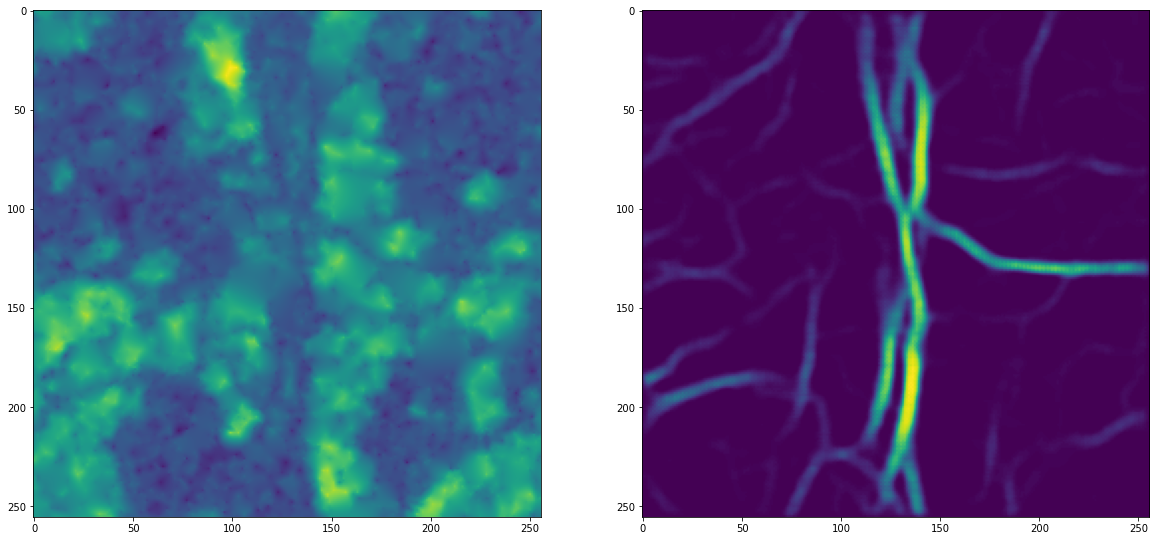

In [77]:
import slidingwindow
from tqdm import tqdm

path = '/media/irro/Irro/HumanFootprint/test.tif'
data = tiff.imread(path)[100:356, 100:356]

patch = (data-data.min())
patch = (patch - patch.min()) * (255.0 / (patch.max() - patch.min()))

data = np.asarray(patch, dtype=np.float32)/255
data = data.reshape(1, data.shape[0], data.shape[1], 1)

pred = model.predict(data)*100
pred = (np.squeeze(pred)).astype(np.uint8)

# Prediction vizualization:
f, axarr = plt.subplots(1,2,figsize=(20,20))
axarr[0].imshow(np.squeeze(data))
axarr[1].imshow(pred)

# cv2.imwrite('/media/irro/Irro/HumanFootprint/test_CNN.png', pred)

### Predicting all TIF files in directory

In [149]:
############ Preparing a list of files for predictions
#### Root directory with tif files:
test_dir = '/media/irro/Irro/Irina/WellPads/CHM_testing'

#### Making a list of tifs which NOT end with... "CNN256.tif" - you should put your own extension
test_list = [os.path.join(test_dir,files) for files in os.listdir(test_dir) if files.endswith(".tif")
            and not files.endswith("CNN256.tif")]
print(test_list)

['/media/irro/Irro/Irina/WellPads/CHM_testing/CHM_0.tif', '/media/irro/Irro/Irina/WellPads/CHM_testing/CHM_4.tif', '/media/irro/Irro/Irina/WellPads/CHM_testing/CHM_5.tif', '/media/irro/Irro/Irina/WellPads/CHM_testing/CHM_6.tif', '/media/irro/Irro/Irina/WellPads/CHM_testing/CHM_8.tif', '/media/irro/Irro/Irina/WellPads/CHM_testing/CHM_9.tif']


In [135]:
################ Predictions for the single tif (with further saving)
predict_tif(model, '/media/irro/Irro/Irina/WellPads/CHM_testing/CHM_9.tif', name = '_over0.5', overla = 0.5)

100%|█████████████████████████████████████████| 377/377 [00:37<00:00, 10.12it/s]


/media/irro/Irro/Irina/WellPads/CHM_testing/CHM_9_test_over0.5_CNN256.tif


In [150]:
######## Predictions for list of tif files (one by one)
for tif in test_list:
    predict_tif(model, tif, name = '_over0.5', overla = 0.5)
    print('\nDone: {}'.format(tif))

100%|█████████████████████████████████████████| 348/348 [00:49<00:00,  7.00it/s]


/media/irro/Irro/Irina/WellPads/CHM_testing/CHM_0_over0.5_CNN256.tif

Done: /media/irro/Irro/Irina/WellPads/CHM_testing/CHM_0.tif


100%|█████████████████████████████████████████| 377/377 [00:37<00:00, 10.01it/s]


/media/irro/Irro/Irina/WellPads/CHM_testing/CHM_4_over0.5_CNN256.tif

Done: /media/irro/Irro/Irina/WellPads/CHM_testing/CHM_4.tif


100%|█████████████████████████████████████████| 377/377 [00:38<00:00,  9.70it/s]


/media/irro/Irro/Irina/WellPads/CHM_testing/CHM_5_over0.5_CNN256.tif

Done: /media/irro/Irro/Irina/WellPads/CHM_testing/CHM_5.tif


100%|█████████████████████████████████████████| 348/348 [00:32<00:00, 10.75it/s]


/media/irro/Irro/Irina/WellPads/CHM_testing/CHM_6_over0.5_CNN256.tif

Done: /media/irro/Irro/Irina/WellPads/CHM_testing/CHM_6.tif


100%|█████████████████████████████████████████| 348/348 [00:39<00:00,  8.87it/s]


/media/irro/Irro/Irina/WellPads/CHM_testing/CHM_8_over0.5_CNN256.tif

Done: /media/irro/Irro/Irina/WellPads/CHM_testing/CHM_8.tif


100%|█████████████████████████████████████████| 377/377 [00:38<00:00,  9.85it/s]


/media/irro/Irro/Irina/WellPads/CHM_testing/CHM_9_over0.5_CNN256.tif

Done: /media/irro/Irro/Irina/WellPads/CHM_testing/CHM_9.tif


# Accuracy Assessment

In [62]:
# shp = '/media/irro/Irro/HumanFootprint/Buffer/trails_random_AA_all.shp'
# gdf = gpd.read_file(shp)

# # Conversion for Label based on value
# gdf['Label'] = gdf['Label'].map({1: 'trail', 0: 'no'})

# # For 'Strong' or 'Weak' in Line_Type, set Label as 'trail'
# gdf.loc[gdf['Line_Type'].isin(['Strong', 'Weak']), 'Label'] = 'trail'

# # Drop the unnecessary columns
# gdf.drop(columns=['CID', 'layer', 'Site_ID'], inplace=True)
# gdf = gdf.reset_index()
# gdf.head()

# # Save the GeoDataFrame to a shapefile
# output_path = "/media/irro/GIS/2023/Human_Footprint/AA/random_points_AA.shp"  # Replace this with your desired path
# gdf.to_file(output_path)

In [6]:
"""
Created on Wed Aug  9 09:25:58 2023

@author: iga.mielczarek
"""
import rasterio 
import geopandas as gpd
from rasterstats import zonal_stats
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
# raster_path = '/media/irro/Irro/HumanFootprint/LiDAR_2022/Kirby_Fen_Original_Test_DEM_10cm_CNNover.tif'
raster_path = '/media/irro/Irro/Kirby/DSM_10cm_trails_CNNover_optimized.tif'

# Open the raster data
with rasterio.open(raster_path) as raster:
    rasterdata = raster.read(1)
    affine_transform = raster.transform
    cell_size = raster.res[0]
    raster_crs = raster.crs

# Read and reproject the shapefile
# shp = '/media/irro/GIS/2023/Human_Footprint/Kirby Trails and Tracks/Trails.shp'
# shp = '/media/irro/Irro/HumanFootprint/trails_fen_iga.shp'
shp = "/media/irro/GIS/2023/Human_Footprint/AA/random_points_AA.shp" 
# shp = '/media/irro/GIS/2023/Human_Footprint/AA/random_points_AA_fen.shp'
gdf = gpd.read_file(shp)
gdf_reprojected = gdf.to_crs(raster_crs)

In [3]:
rasterdata.shape

(29924, 47112)

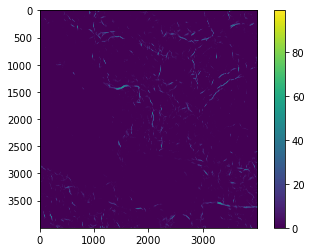

In [4]:
# Plot the 'arr' for visualization
plt.imshow(rasterdata[1000:5000,1000:5000], cmap='viridis')
plt.colorbar()
plt.show()

In [53]:
# import pandas as pd

# # Buffer the points
# buffer_radius = 2
# AA = {}
# data = []
# p = 10
# area_thre = 0.2


# # Iterate over weak and strong trails
# for line_type in ["Weak", "Strong"]:
#     filtered_gdf = gdf_reprojected[gdf_reprojected["Line_Type"] == line_type]
#     buffer_shapefile_trails = filtered_gdf['geometry'].buffer(buffer_radius)

#     AA[line_type] = {}

#     # Create a binary map based on the threshold
#     arr = np.where(rasterdata < p, 0, 1)

#     geometries = [feature['geometry'] for feature in buffer_shapefile_trails.to_crs(raster.crs).__geo_interface__['features']]
#     stats = zonal_stats(geometries, arr, affine=affine_transform, stats="count mean", nodata=-999)

#     # Calculate the threshold for number of pixels. 0.1 here represents 10% of the buffer's area.
#     # We're approximating the buffer area as a circle using the formula: pi * r^2.
#     buffer_area_pixel_count = (buffer_radius**2) * np.pi / (cell_size**2)
#     pixel_threshold = area_thre * buffer_area_pixel_count

#     for index, stat in enumerate(stats):
#         if stat['mean'] is not None:
#             trail_pixel_count = stat['count'] * stat['mean']  # Number of pixels above threshold
#             relative_area = trail_pixel_count / buffer_area_pixel_count  # Proportion to total pixels in the buffer
#         else:
#             relative_area = 0

#         # Store each trail's data
#         data.append({
#             'Trail_ID': filtered_gdf.iloc[index].ID,
#             'Line_Type': line_type,
#             'Mean': stat.get('mean', 0),
#             'Count': stat.get('count', 0),
#             'Relative_Area': relative_area
#         })

#     true_positives = sum(1 for stat in stats if stat['mean'] is not None and stat['count'] * stat['mean'] > pixel_threshold)
#     false_negatives = len(stats) - true_positives

#     print(f"For {line_type} and p = {p}: True Positives = {true_positives}, False Negatives = {false_negatives}")
#     AA[line_type][p] = {"TP": true_positives, "FN": false_negatives}

# # Convert the data list to a DataFrame
# df = pd.DataFrame(data)

For Weak and p = 10: True Positives = 30, False Negatives = 15
For Strong and p = 10: True Positives = 53, False Negatives = 16


### Working AA

In [5]:
# Buffer the points
buffer_radius = 1.5
AA = {}
data = []
p = 15
area_thre = 0.1

# Calculate the threshold for the number of pixels.
buffer_area_pixel_count = (buffer_radius**2) * np.pi / (cell_size**2)
pixel_threshold = area_thre * buffer_area_pixel_count

# Initialize the counts for TP, FP, TN, FN
TP, FP, TN, FN = 0, 0, 0, 0

buffer_shapefile_trails = gdf_reprojected['geometry'].buffer(buffer_radius)

# for p in [5, 10, 15, 20, 25, 30, 40, 50]
# Create a binary map based on the threshold
arr = np.where(rasterdata < p, 0, 1)

geometries = [feature['geometry'] for feature in buffer_shapefile_trails.to_crs(raster.crs).__geo_interface__['features']]
stats = zonal_stats(geometries, arr, affine=affine_transform, stats="count mean", nodata=-999)

for index, stat in enumerate(stats):
    # Check if the point has any trail pixels in its buffer
    is_trail_in_buffer = (stat['mean'] is not None) and (stat['count'] * stat['mean'] > pixel_threshold)

    # Compare with the actual Label
    ground_truth = gdf_reprojected.iloc[index]['Label']

    classification = ""
    if is_trail_in_buffer and ground_truth == "trail":
        TP += 1
        classification = "TP"
    elif is_trail_in_buffer and ground_truth == "no":
        FP += 1
        classification = "FP"
    elif not is_trail_in_buffer and ground_truth == "trail":
        FN += 1
        classification = "FN"
    elif not is_trail_in_buffer and ground_truth == "no":
        TN += 1
        classification = "TN"

    # Store each trail's data
    data.append({
        'Trail_ID': gdf_reprojected.iloc[index]['index'],
        'Label': gdf_reprojected.iloc[index]['Label'],
        'Mean': stat.get('mean', 0),
        'Count': stat.get('count', 0),
        'Relative_Area': stat['count'] * stat['mean'] / buffer_area_pixel_count if stat['mean'] is not None else 0,
        'Classification': classification
    })

print(f"For p = {p}: TP = {TP}, FP = {FP}, TN = {TN}, FN = {FN}")
AA[p] = {"TP": TP, "FP": FP, "TN": TN, "FN": FN}

# Convert the data list to a DataFrame
df = pd.DataFrame(data)

accuracy = (TP + TN) / (TP + TN + FP + FN)
precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1_score = 2 * (precision * recall) / (precision + recall)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1_score:.2f}")

# Convert the DataFrame to a GeoDataFrame
gdf_out = gpd.GeoDataFrame(df, geometry=gdf_reprojected['geometry'].tolist(), crs=gdf_reprojected.crs)

# Save to shapefile
output_shp = '{}_for_{}.shp'.format(shp[:-4], os.path.basename(raster_path)[:-4])
print(output_shp)
gdf_out.to_file(output_shp)

For p = 15: TP = 397, FP = 103, TN = 1428, FN = 82
Accuracy: 0.91
Precision: 0.79
Recall: 0.83
F1 Score: 0.81


NameError: name 'os' is not defined

In [7]:
# Convert the DataFrame to a GeoDataFrame
gdf_out = gpd.GeoDataFrame(df, geometry=gdf_reprojected['geometry'].tolist(), crs=gdf_reprojected.crs)

# Save to shapefile
output_shp = '{}_for_{}.shp'.format(shp[:-4], os.path.basename(raster_path)[:-4])
print(output_shp)
gdf_out.to_file(output_shp)

/media/irro/GIS/2023/Human_Footprint/AA/random_points_AA_for_DSM_10cm_trails_CNNover_optimized.shp


/home/irro/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/tmp/ipykernel_1488827/1577552380.py:7: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_out.to_file(output_shp)


### Precision-Recall Curve

In [ ]:
import pandas as pd
import numpy as np

# Buffer the points
buffer_radius = 2
data = []
p_values = [5, 10, 13, 16, 20, 23, 26, 30, 40, 50, 60, 70, 80]
area_thre = 0.1

# Calculate the threshold for the number of pixels.
buffer_area_pixel_count = (buffer_radius**2) * np.pi / (cell_size**2)

results = []

for p in p_values:
    # Initialize the counts for TP, FP, TN, FN
    TP, FP, TN, FN = 0, 0, 0, 0

    pixel_threshold = area_thre * buffer_area_pixel_count
    buffer_shapefile_trails = gdf_reprojected['geometry'].buffer(buffer_radius)

    # Create a binary map based on the threshold
    arr = np.where(rasterdata < p, 0, 1)

    geometries = [feature['geometry'] for feature in buffer_shapefile_trails.to_crs(raster.crs).__geo_interface__['features']]
    # Get the sum of trail pixels for each buffer instead of mean.
    stats = zonal_stats(geometries, arr, affine=affine_transform, stats="sum", nodata=-999)

    for index, stat in enumerate(stats):
        # Check if the point has any trail pixels in its buffer
        is_trail_in_buffer = (stat['sum'] > pixel_threshold) 

        # Compare with the actual Label
        ground_truth = gdf_reprojected.iloc[index]['Label']

        if is_trail_in_buffer and ground_truth == "trail":
            TP += 1
        elif is_trail_in_buffer and ground_truth == "no":
            FP += 1
        elif not is_trail_in_buffer and ground_truth == "trail":
            FN += 1
        elif not is_trail_in_buffer and ground_truth == "no":
            TN += 1
            
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0

    results.append({
        'p': p,
        'TP': TP,
        'FP': FP,
        'TN': TN,
        'FN': FN,
        'Precision': precision,
        'Recall': recall
    })
    
    print(f'P is {p}%')
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1_score = 2 * (precision * recall) / (precision + recall)

    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1_score:.2f}")

# Convert the results list to a DataFrame
results_df = pd.DataFrame(results)

# Now you have a DataFrame named results_df with TP, FP, TN, FN, precision, and recall for each p.


P is 5%
Accuracy: 0.88
Precision: 0.69
Recall: 0.91
F1 Score: 0.78
P is 10%
Accuracy: 0.90
Precision: 0.74
Recall: 0.86
F1 Score: 0.80
P is 13%
Accuracy: 0.90
Precision: 0.77
Recall: 0.83
F1 Score: 0.80
P is 16%
Accuracy: 0.90
Precision: 0.78
Recall: 0.81
F1 Score: 0.80


In [121]:
results_df

,p,TP,FP,TN,FN,Precision,Recall
0,5,109,116,332,10,0.484444,0.915966
1,10,100,70,378,19,0.588235,0.840336
2,15,96,44,404,23,0.685714,0.806723
3,20,88,37,411,31,0.704000,0.739496
4,25,75,31,417,44,0.707547,0.630252
5,30,71,23,425,48,0.755319,0.596639
6,40,62,16,432,57,0.794872,0.521008
7,50,53,13,435,66,0.803030,0.445378


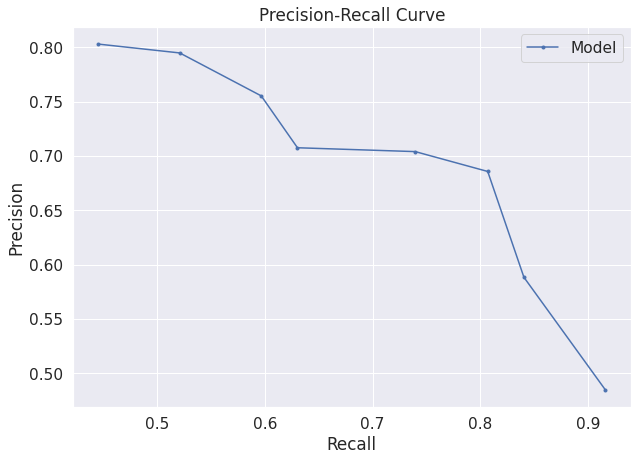

In [122]:
import matplotlib.pyplot as plt

# Extract precision and recall values from results_df
precisions = results_df['Precision']
recalls = results_df['Recall']

# Plot the precision-recall curve
plt.figure(figsize=(10, 7))
plt.plot(recalls, precisions, marker='.', label='Model')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.legend()
plt.show()


In [11]:
# results

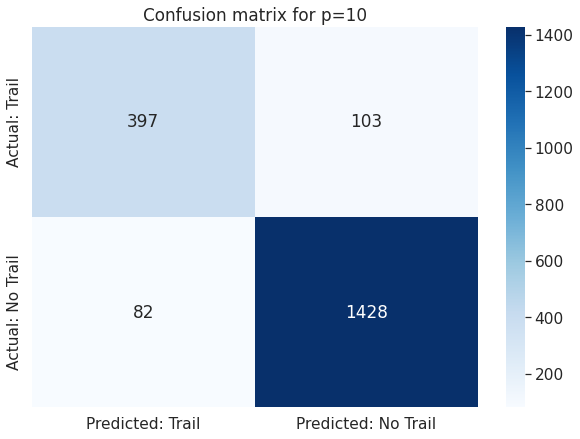

In [8]:
import seaborn as sns
#  Confusion matrix
data = np.array([[TP, FP], [FN, TN]])

df_cm = pd.DataFrame(data, columns=["Predicted: Trail", "Predicted: No Trail"], 
                     index=["Actual: Trail", "Actual: No Trail"])

plt.figure(figsize=(10,7))
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True, fmt="g", cmap="Blues")

plt.title('Confusion matrix for p=10')
plt.show()


In [9]:
accuracy = (TP + TN) / (TP + TN + FP + FN)
precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1_score = 2 * (precision * recall) / (precision + recall)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1_score:.2f}")

Accuracy: 0.91
Precision: 0.79
Recall: 0.83
F1 Score: 0.81


# Extract profiles

In [125]:
import geopandas as gpd
import rasterio
import numpy as np

# Paths
raster_path = '/media/irro/GIS/2023/Human_Footprint/test3.tif'
shapefile_path = '/media/irro/GIS/Shapes/test.shp'

In [126]:
import numpy as np
from shapely.geometry import Point

lines = gpd.read_file(shapefile_path)

# Function to sample points along a line
def sample_points_along_line(line, interval):
    length = line.length
    distances = np.arange(0, length, interval)
    return [line.interpolate(distance) for distance in distances]

# Function to get raster values for a list of points
def raster_values_at_points(src, points):
    values = []
    for point in points:
        col, row = src.index(point.x, point.y)
        values.append(src.read(1)[col, row])
    return values

# Sample points and extract raster values
profiles = []  # To store the extracted raster values for each line

with rasterio.open(raster_path) as src:
    for line in lines.geometry:
        print(line)
        sampled_points = sample_points_along_line(line, 0.1)
        profile = raster_values_at_points(src, sampled_points)
        profiles.append(profile)

# Now, `profiles` contains the extracted raster values for each line. 
# You can plot or analyze them further as needed.


LINESTRING (488565.4416775364 6134858.325086943, 488589.1148583146 6134844.429959095)
LINESTRING (488587.2768784405 6134855.60487673, 488569.7057908443 6134838.548423498)


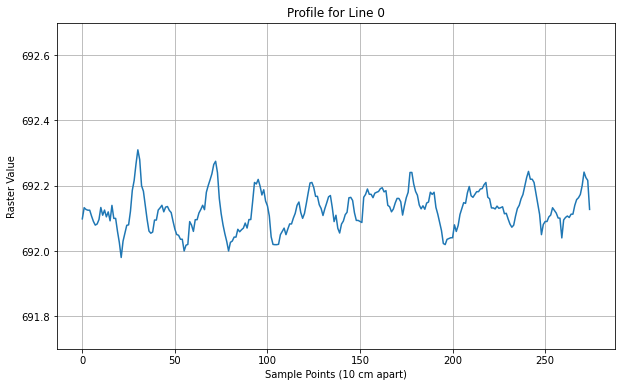

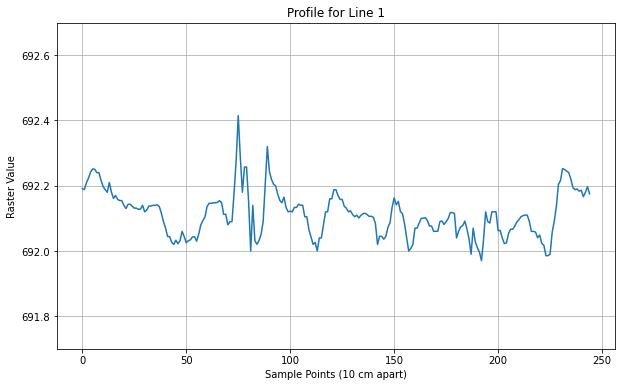

In [127]:
import matplotlib.pyplot as plt

# Assuming profiles is the list of extracted profiles you provided

for idx, profile in enumerate(profiles):
    plt.figure(figsize=(10,6))
    plt.plot(profile)
    plt.title(f'Profile for Line {idx}')
    plt.xlabel('Sample Points (10 cm apart)')
    plt.ylabel('Raster Value')
    plt.ylim(691.7, 692.7) 
    plt.grid(True)
    plt.show()

### Buffer around points

In [3]:
# import geopandas as gpd
# from shapely.geometry import Point, Polygon

# # Load your point shapefile into a GeoDataFrame
# gdf = gpd.read_file("/media/irro/Irro/HumanFootprint/randompoints_AA_05cm.shp")

# # Function to create a square buffer around a point
# def square_buffer(point, distance=25):  # 25m on each side to get a 50m width
#     x, y = point.x, point.y
#     # Creating a square polygon with the provided distance
#     square = Polygon([
#         (x - distance, y - distance),
#         (x + distance, y - distance),
#         (x + distance, y + distance),
#         (x - distance, y + distance)
#     ])
#     return square

# # Apply the function to each point in the GeoDataFrame
# gdf['geometry'] = gdf.geometry.apply(square_buffer)

# # Save the GeoDataFrame with the square buffers to a new shapefile
# output_path = "/media/irro/Irro/HumanFootprint/randompoints_AA_05cm_buffered.shp"
# gdf.to_file(output_path)

# print(f"Saved buffered shapefile to: {output_path}")


### Resaving TIFs

In [2]:
# ########### RESAVING if QGIS Crashes!

# import rasterio


# input_file = "/media/irro/Irro/Surmont/LiDAR_2022/DTM_Surmont_mosaic_50cm_CNN9ep_256_179max.tif"
# output_file = "/media/irro/Irro/Surmont/LiDAR_2022/DTM_Surmont_mosaic_50cm_CNN9ep_256max.tif"

# # Read the .tif file using rasterio
# with rasterio.open(input_file, 'r') as src:
#     # Get the data for each band in the source dataset
#     data = src.read()

#     # Write the data to a new .tif file with a different name
#     with rasterio.open(output_file, 'w', **src.meta) as dst:
#         for i, band in enumerate(data, start=1):
#             dst.write(band, i)

# print(f"Saved the file as {output_file}")
